# KAMA-MSR Model Comparison and Analysis

This notebook loads multiple KAMA-MSR models, compares their characteristics, and identifies potential areas for improvement.

## 1. Import Required Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import skew, kurtosis
import pickle
import os
from typing import Dict, List, Tuple
from datetime import datetime
import warnings

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 4)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load All Models from Directory

In [39]:
def load_all_models(sub_folder: str, edte_sub_folder: str, n_regimes: int = 2) -> Dict:
    """
    Load all KAMA-MSR models from a specified directory.
    
    Parameters:
    -----------
    sub_folder : str
        Asset type subfolder (e.g., 'us_equity', 'international_index')
    edte_sub_folder : str
        End date subfolder (e.g., '20220101')
    n_regimes : int
        Number of MSR regimes (used to construct filename)
    
    Returns:
    --------
    Dict : Dictionary with asset names as keys and loaded models as values
    """
    models = {}
    model_dir = f'saved_models/KAMA_MSR/{sub_folder}/{edte_sub_folder}'
    
    if not os.path.exists(model_dir):
        print(f"❌ Directory not found: {model_dir}")
        return models
    
    print(f"Loading models from: {model_dir}\n")
    
    # Get all pickle files
    pkl_files = [f for f in os.listdir(model_dir) if f.endswith('.pkl') and f != 'metadata.pkl']
    
    for filename in pkl_files:
        filepath = os.path.join(model_dir, filename)
        
        try:
            with open(filepath, 'rb') as f:
                model = pickle.load(f)
            
            # Extract asset name from filename
            # Format: AssetName_KAMA-MSR_X-regimes.pkl
            asset_name = filename.replace('_KAMA-MSR_', '|||').split('|||')[0]
            asset_name = asset_name.replace('_', ' ')
            
            models[asset_name] = model
            print(f"✓ Loaded: {asset_name}")
            
        except Exception as e:
            print(f"❌ Error loading {filename}: {str(e)}")
    
    print(f"\n{'='*80}")
    print(f"Successfully loaded {len(models)} models")
    print(f"{'='*80}\n")
    
    return models

def get_available_model_folders() -> pd.DataFrame:
    """
    Scan the saved_models directory to show available model configurations.
    
    Returns:
    --------
    pd.DataFrame : Summary of available model folders
    """
    base_dir = 'saved_models/KAMA_MSR'
    
    if not os.path.exists(base_dir):
        print(f"❌ Base directory not found: {base_dir}")
        return pd.DataFrame()
    
    folders = []
    
    for asset_type in os.listdir(base_dir):
        asset_type_path = os.path.join(base_dir, asset_type)
        
        if not os.path.isdir(asset_type_path):
            continue
            
        for date_folder in os.listdir(asset_type_path):
            date_folder_path = os.path.join(asset_type_path, date_folder)
            
            if not os.path.isdir(date_folder_path):
                continue
            
            # Count models
            pkl_files = [f for f in os.listdir(date_folder_path) 
                        if f.endswith('.pkl') and f != 'metadata.pkl']
            
            if pkl_files:
                folders.append({
                    'Asset Type': asset_type,
                    'End Date': date_folder,
                    'N Models': len(pkl_files),
                    'Path': f"{asset_type}/{date_folder}"
                })
    
    df = pd.DataFrame(folders)
    return df.sort_values(['Asset Type', 'End Date']) if not df.empty else df

In [40]:
# Display available model configurations
available_models = get_available_model_folders()
print("Available Model Configurations:")
print("="*80)
if not available_models.empty:
    display(available_models)
else:
    print("No models found!")

Available Model Configurations:


,Asset Type,End Date,N Models,Path
1,commodity,20220101,12,commodity/20220101
3,us_bond,20220101,3,us_bond/20220101
0,us_equity,20220101,26,us_equity/20220101
2,us_traded_international_equity_etfs,20220101,8,us_traded_international_equity_etfs/20220101


In [41]:
# Load models - ADJUST THESE PARAMETERS
sub_folder = 'us_equity'  # Change to your asset type
edte_sub_folder = '20220101'  # Change to your date
n_regimes = 2

models = load_all_models(sub_folder, edte_sub_folder, n_regimes)

if models:
    print(f"\nLoaded models for assets:")
    for i, asset_name in enumerate(models.keys(), 1):
        print(f"  {i:2d}. {asset_name}")

Loading models from: saved_models/KAMA_MSR/us_equity/20220101

✓ Loaded: Consumer Discretionary Select Sector SPDR
✓ Loaded: Nasdaq 100
✓ Loaded: Consumer Staples Select Sector SPDR
✓ Loaded: iShares Micro-Cap ETF
✓ Loaded: Invesco S&P 500 Equal Weight ETF
✓ Loaded: Nasdaq Composite
✓ Loaded: iShares Russell 2000 ETF
✓ Loaded: Financial Select Sector SPDR
✓ Loaded: iShares S&P 500 Value ETF
✓ Loaded: Health Care Select Sector SPDR
✓ Loaded: iShares Russell 2000 Value ETF
✓ Loaded: iShares S&P 500 Growth ETF
✓ Loaded: Invesco QQQ Trust
✓ Loaded: Russell 2000
✓ Loaded: SPDR Dow Jones Industrial Average ETF
✓ Loaded: SPDR S&P 500 ETF
✓ Loaded: iShares Russell 2000 Growth ETF
✓ Loaded: Dow Jones Industrial Average
✓ Loaded: iShares Russell Mid-Cap ETF
✓ Loaded: S&P 500
✓ Loaded: Technology Select Sector SPDR
✓ Loaded: Fidelity Nasdaq Composite Index ETF
✓ Loaded: Energy Select Sector SPDR
✓ Loaded: Materials Select Sector SPDR
✓ Loaded: Utilities Select Sector SPDR
✓ Loaded: Industrial Sel

## 3. Extract Model Metadata and Parameters

In [42]:
def extract_model_metadata(models: Dict) -> pd.DataFrame:
    """
    Extract comprehensive metadata from all loaded models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Comprehensive metadata for all models
    """
    metadata = []
    
    for asset_name, model in models.items():
        try:
            # Basic info
            n_data_points = len(model.prices) if model.prices is not None else 0
            n_regimes_msr = model.msr.n_regimes
            n_combined_regimes = model.n_combined_regimes
            
            # KAMA parameters
            kama_n = model.kama.n
            kama_n_fast = model.kama.n_fast
            kama_n_slow = model.kama.n_slow
            gamma = model.gamma
            
            # Regime labels
            regime_labels = model.regime_labels.dropna()
            n_regime_changes = (regime_labels.diff() != 0).sum()
            
            # Regime distribution
            regime_counts = regime_labels.value_counts()
            regime_pcts = regime_counts / len(regime_labels) * 100
            
            # MSR parameters
            msr_means = model.msr.means
            msr_stds = model.msr.stds
            msr_betas = model.msr.betas
            
            # Build metadata dict
            meta = {
                'Asset': asset_name,
                'N_Data_Points': n_data_points,
                'N_MSR_Regimes': n_regimes_msr,
                'N_Combined_Regimes': n_combined_regimes,
                'KAMA_n': kama_n,
                'KAMA_n_fast': kama_n_fast,
                'KAMA_n_slow': kama_n_slow,
                'Filter_gamma': gamma,
                'N_Regime_Changes': n_regime_changes,
                'Avg_Regime_Duration': len(regime_labels) / (n_regime_changes + 1),
            }
            
            # Add regime-specific data
            for i in range(n_combined_regimes):
                meta[f'Regime_{i}_Pct'] = regime_pcts.get(i, 0)
                meta[f'Regime_{i}_Count'] = regime_counts.get(i, 0)
            
            # Add MSR parameters
            for i in range(n_regimes_msr):
                meta[f'MSR_Mean_{i}'] = msr_means[i]
                meta[f'MSR_Std_{i}'] = msr_stds[i]
                meta[f'MSR_Beta_{i}'] = msr_betas[i]
            
            # Add transition probabilities
            for i in range(n_regimes_msr):
                for j in range(n_regimes_msr):
                    meta[f'Trans_P_{i}_to_{j}'] = model.msr.transition_probs[i, j]
            
            metadata.append(meta)
            
        except Exception as e:
            print(f"❌ Error extracting metadata for {asset_name}: {str(e)}")
    
    df = pd.DataFrame(metadata)
    return df

# Extract metadata
metadata_df = extract_model_metadata(models)

print("\nModel Metadata Summary:")
print("="*80)
display(metadata_df.head())

print(f"\nShape: {metadata_df.shape}")
print(f"Columns: {list(metadata_df.columns)}")


Model Metadata Summary:


,Asset,N_Data_Points,N_MSR_Regimes,N_Combined_Regimes,KAMA_n,KAMA_n_fast,KAMA_n_slow,Filter_gamma,N_Regime_Changes,Avg_Regime_Duration,Regime_0_Pct,Regime_0_Count,Regime_1_Pct,Regime_1_Count,Regime_2_Pct,Regime_2_Count,Regime_3_Pct,Regime_3_Count,MSR_Mean_0,MSR_Std_0,MSR_Beta_0,MSR_Mean_1,MSR_Std_1,MSR_Beta_1,Trans_P_0_to_0,Trans_P_0_to_1,Trans_P_1_to_0,Trans_P_1_to_1
0,Consumer Discretionary Select Sector SPDR,5795,2,4,16,10,50,0.5,114,50.2435,74.1260,4283,17.5320,1013,1.0557,61,7.2863,421,0.0005,0.0125,-0.0062,-0.0012,0.0370,-0.0170,0.9931,0.0069,0.0693,0.9307
1,Nasdaq 100,8064,2,4,27,10,60,2.0,91,87.3478,73.6063,5915,8.4370,678,8.1010,651,9.8556,792,0.0010,0.0127,0.0036,-0.0019,0.0333,-0.0617,0.9933,0.0067,0.0307,0.9693
2,Consumer Staples Select Sector SPDR,5795,2,4,9,10,60,0.5,134,42.8519,71.9965,4165,25.7736,1491,0.1729,10,2.0570,119,0.0002,0.0103,-0.0196,-0.0018,0.0492,-0.0189,0.9951,0.0049,0.1785,0.8215
3,iShares Micro-Cap ETF,4124,2,4,8,2,40,2.0,255,16.0742,54.8481,2257,36.5735,1505,3.4022,140,5.1762,213,0.0005,0.0140,-0.0038,-0.0027,0.0436,-0.0531,0.9954,0.0046,0.0491,0.9509
4,Invesco S&P 500 Equal Weight ETF,4703,2,4,10,10,50,1.0,70,66.0845,79.5183,3731,12.3615,580,0.9591,45,7.1611,336,0.0006,0.0114,-0.0053,-0.0018,0.0401,-0.0391,0.9960,0.0040,0.0427,0.9573



Shape: (26, 28)
Columns: ['Asset', 'N_Data_Points', 'N_MSR_Regimes', 'N_Combined_Regimes', 'KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow', 'Filter_gamma', 'N_Regime_Changes', 'Avg_Regime_Duration', 'Regime_0_Pct', 'Regime_0_Count', 'Regime_1_Pct', 'Regime_1_Count', 'Regime_2_Pct', 'Regime_2_Count', 'Regime_3_Pct', 'Regime_3_Count', 'MSR_Mean_0', 'MSR_Std_0', 'MSR_Beta_0', 'MSR_Mean_1', 'MSR_Std_1', 'MSR_Beta_1', 'Trans_P_0_to_0', 'Trans_P_0_to_1', 'Trans_P_1_to_0', 'Trans_P_1_to_1']


## 4. Compare KAMA Parameters Across Assets

In [43]:
# Summary statistics for KAMA parameters
kama_cols = ['KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow', 'Filter_gamma']
kama_summary = metadata_df[['Asset'] + kama_cols].describe()

print("KAMA Parameter Summary Statistics:")
print("="*80)
display(kama_summary)

# Identify unique parameter combinations
unique_kama = metadata_df[kama_cols].drop_duplicates()
print(f"\nNumber of unique KAMA parameter combinations: {len(unique_kama)}")
print("\nUnique KAMA configurations:")
display(unique_kama)

KAMA Parameter Summary Statistics:


,KAMA_n,KAMA_n_fast,KAMA_n_slow,Filter_gamma
count,26.0000,26.0000,26.0000,26.0000
mean,20.8462,9.4231,51.3462,1.3750
std,8.2786,1.7245,11.0957,0.5489
min,5.0000,2.0000,25.0000,0.5000
25%,15.2500,10.0000,50.0000,1.0000
50%,23.0000,10.0000,55.0000,1.5000
75%,26.7500,10.0000,60.0000,1.9375
max,30.0000,10.0000,60.0000,2.0000



Number of unique KAMA parameter combinations: 25

Unique KAMA configurations:


,KAMA_n,KAMA_n_fast,KAMA_n_slow,Filter_gamma
0,16,10,50,0.50
1,27,10,60,2.00
2,9,10,60,0.50
3,8,2,40,2.00
4,10,10,50,1.00
5,23,10,60,1.75
6,12,10,30,0.50
7,30,10,50,2.00
8,7,9,55,1.00
9,30,10,60,1.50


IndexError: index 3 is out of bounds for axis 0 with size 3

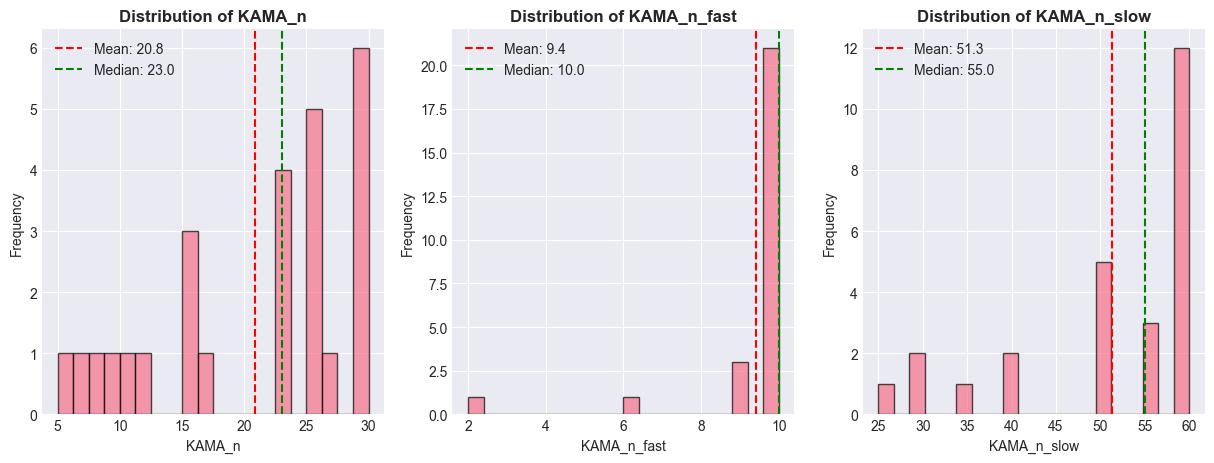

In [44]:
# Visualize KAMA parameters
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(kama_cols):
    ax = axes[idx]
    metadata_df[col].hist(bins=20, ax=ax, edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.axvline(metadata_df[col].mean(), color='red', linestyle='--', 
               label=f'Mean: {metadata_df[col].mean():.1f}')
    ax.axvline(metadata_df[col].median(), color='green', linestyle='--', 
               label=f'Median: {metadata_df[col].median():.1f}')
    ax.legend()

plt.tight_layout()
plt.show()

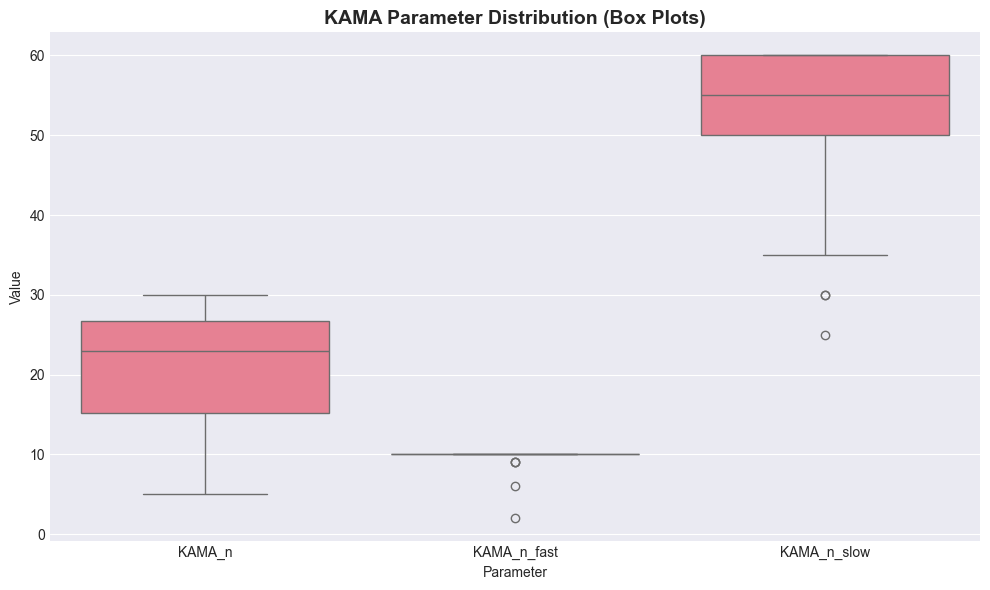


KAMA Parameter Outliers (values > 1.5 IQR):

KAMA_n_fast:
  iShares Micro-Cap ETF: 2
  iShares S&P 500 Value ETF: 9
  iShares S&P 500 Growth ETF: 9
  SPDR S&P 500 ETF: 9
  Utilities Select Sector SPDR: 6

KAMA_n_slow:
  iShares Russell 2000 ETF: 30
  iShares Russell Mid-Cap ETF: 25
  Fidelity Nasdaq Composite Index ETF: 30


In [ ]:
# Box plots for KAMA parameters
fig, ax = plt.subplots(figsize=(10, 6))

kama_data = metadata_df[kama_cols].melt(var_name='Parameter', value_name='Value')
sns.boxplot(data=kama_data, x='Parameter', y='Value', ax=ax)
ax.set_title('KAMA Parameter Distribution (Box Plots)', fontsize=14, fontweight='bold')
ax.set_ylabel('Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Identify outliers
print("\nKAMA Parameter Outliers (values > 1.5 IQR):")
print("="*80)
for col in kama_cols:
    Q1 = metadata_df[col].quantile(0.25)
    Q3 = metadata_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = metadata_df[(metadata_df[col] < Q1 - 1.5*IQR) | (metadata_df[col] > Q3 + 1.5*IQR)]
    if len(outliers) > 0:
        print(f"\n{col}:")
        for _, row in outliers.iterrows():
            print(f"  {row['Asset']}: {row[col]}")

## 5. Compare MSR Parameters Across Assets

In [ ]:
# Extract MSR parameter columns
msr_mean_cols = [col for col in metadata_df.columns if col.startswith('MSR_Mean_')]
msr_std_cols = [col for col in metadata_df.columns if col.startswith('MSR_Std_')]
msr_beta_cols = [col for col in metadata_df.columns if col.startswith('MSR_Beta_')]

print("MSR Parameter Summary Statistics:")
print("="*80)

print("\nMSR Means:")
display(metadata_df[['Asset'] + msr_mean_cols].describe())

print("\nMSR Standard Deviations:")
display(metadata_df[['Asset'] + msr_std_cols].describe())

print("\nMSR Betas:")
display(metadata_df[['Asset'] + msr_beta_cols].describe())

MSR Parameter Summary Statistics:

MSR Means:


,MSR_Mean_0,MSR_Mean_1
count,26.0000,26.0000
mean,0.0006,-0.0027
std,0.0002,0.0010
min,0.0002,-0.0051
25%,0.0005,-0.0030
50%,0.0005,-0.0023
75%,0.0006,-0.0019
max,0.0010,-0.0012



MSR Standard Deviations:


,MSR_Std_0,MSR_Std_1
count,26.0000,26.0000
mean,0.0122,0.0417
std,0.0014,0.0097
min,0.0101,0.0306
25%,0.0113,0.0363
50%,0.0121,0.0391
75%,0.0129,0.0458
max,0.0157,0.0795



MSR Betas:


,MSR_Beta_0,MSR_Beta_1
count,26.0000,26.0000
mean,-0.0074,-0.0584
std,0.0082,0.0611
min,-0.0196,-0.3494
25%,-0.0138,-0.0564
50%,-0.0074,-0.0490
75%,-0.0040,-0.0397
max,0.0124,-0.0170


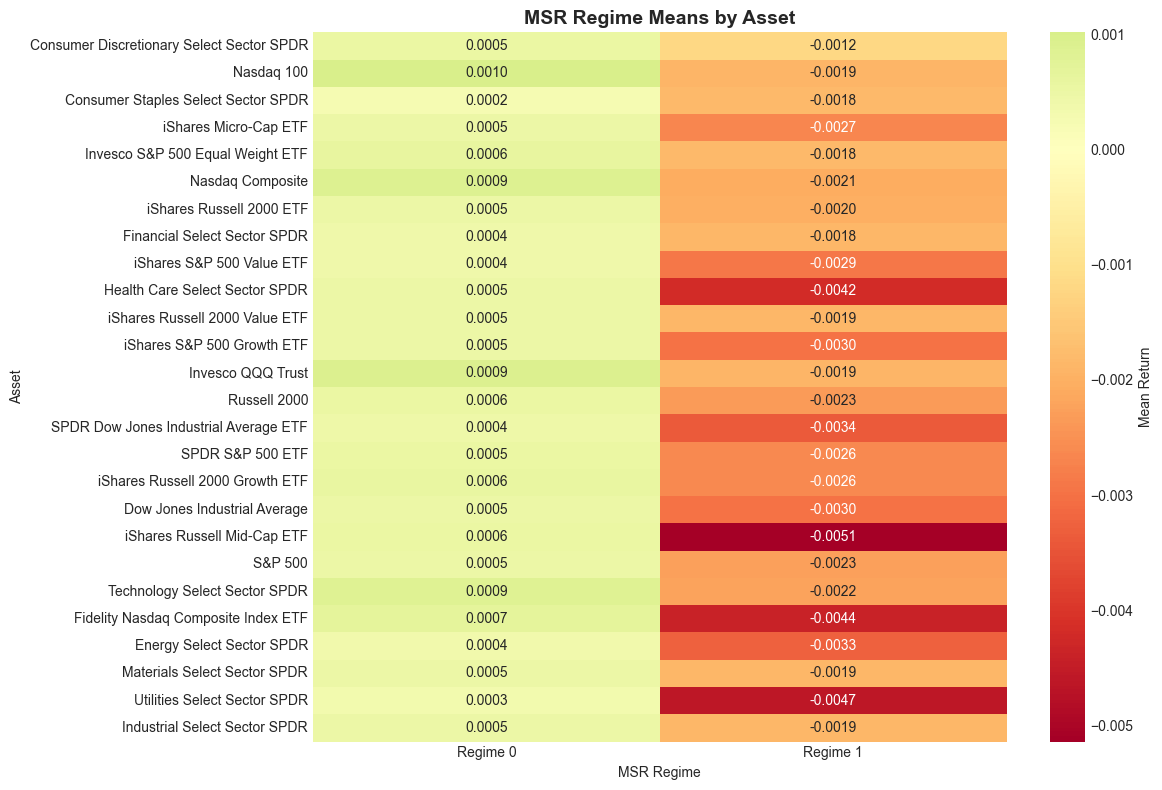

In [ ]:
# Heatmap of MSR means
plt.figure(figsize=(12, 8))

msr_means_data = metadata_df[['Asset'] + msr_mean_cols].set_index('Asset')
msr_means_data.columns = [col.replace('MSR_Mean_', 'Regime ') for col in msr_means_data.columns]

sns.heatmap(msr_means_data, annot=True, fmt='.4f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Mean Return'})
plt.title('MSR Regime Means by Asset', fontsize=14, fontweight='bold')
plt.ylabel('Asset')
plt.xlabel('MSR Regime')
plt.tight_layout()
plt.show()

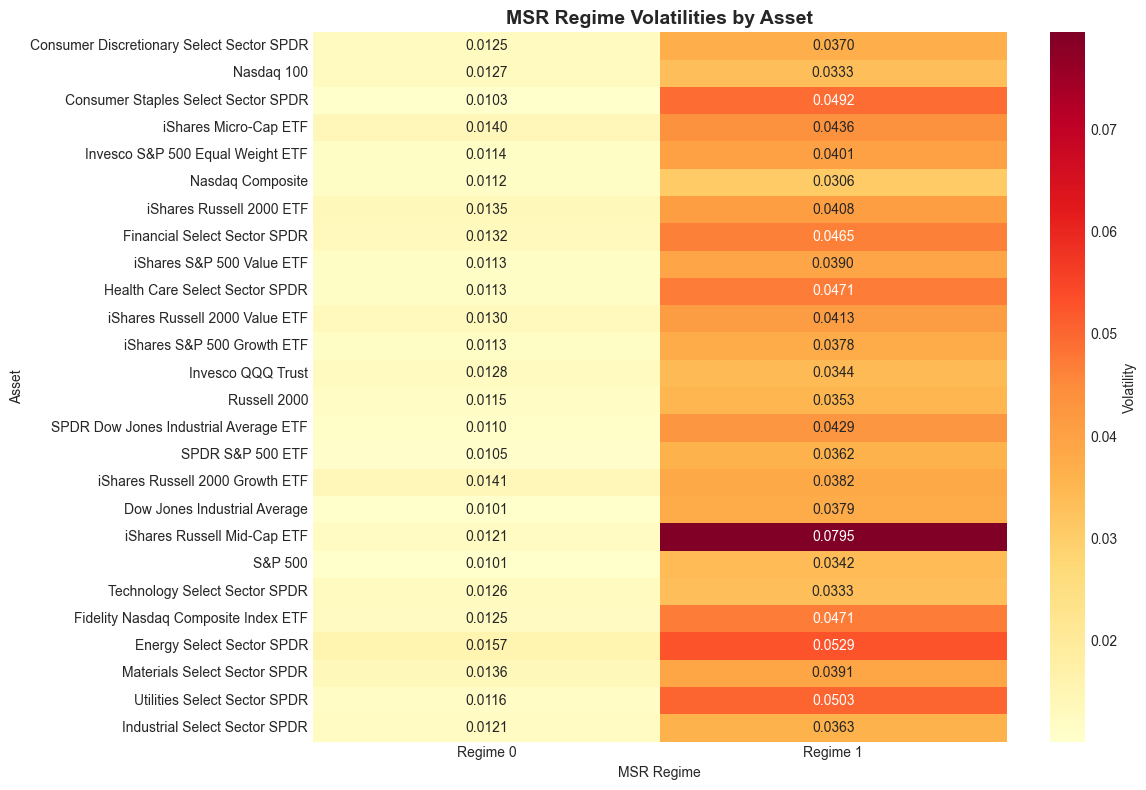

In [ ]:
# Heatmap of MSR volatilities
plt.figure(figsize=(12, 8))

msr_stds_data = metadata_df[['Asset'] + msr_std_cols].set_index('Asset')
msr_stds_data.columns = [col.replace('MSR_Std_', 'Regime ') for col in msr_stds_data.columns]

sns.heatmap(msr_stds_data, annot=True, fmt='.4f', cmap='YlOrRd', 
            cbar_kws={'label': 'Volatility'})
plt.title('MSR Regime Volatilities by Asset', fontsize=14, fontweight='bold')
plt.ylabel('Asset')
plt.xlabel('MSR Regime')
plt.tight_layout()
plt.show()

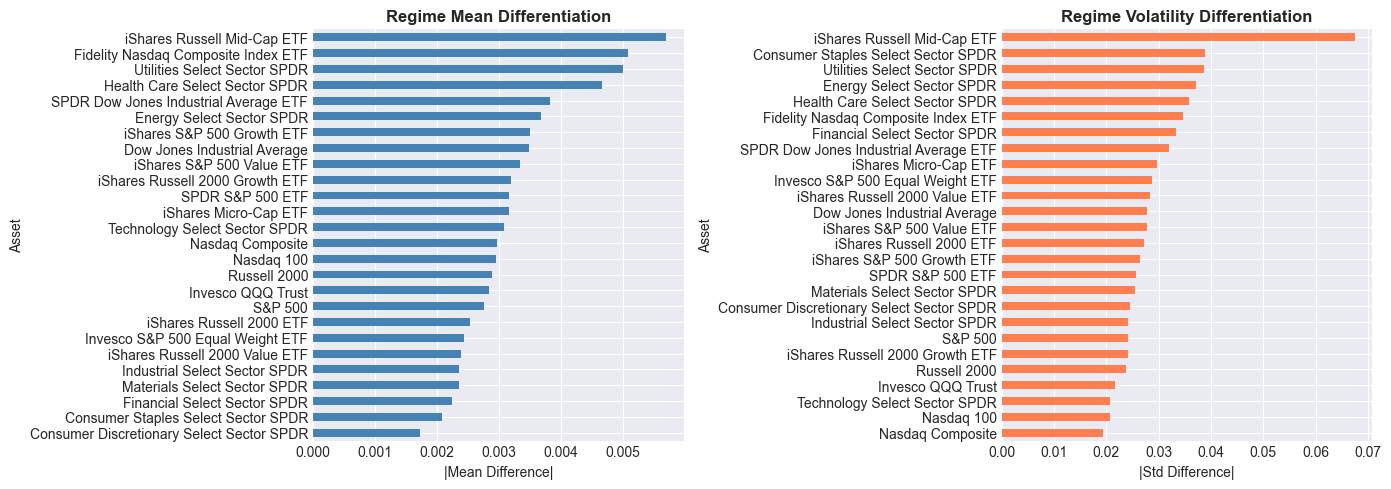


Assets with WEAK Regime Differentiation:

Lowest Mean Differentiation:


,Asset,Mean_Diff,MSR_Mean_0,MSR_Mean_1
0,Consumer Discretionary Select Sector SPDR,0.0017,0.0005,-0.0012
2,Consumer Staples Select Sector SPDR,0.0021,0.0002,-0.0018
7,Financial Select Sector SPDR,0.0022,0.0004,-0.0018
23,Materials Select Sector SPDR,0.0024,0.0005,-0.0019
25,Industrial Select Sector SPDR,0.0024,0.0005,-0.0019



Lowest Volatility Differentiation:


,Asset,Std_Diff,MSR_Std_0,MSR_Std_1
5,Nasdaq Composite,0.0193,0.0112,0.0306
1,Nasdaq 100,0.0207,0.0127,0.0333
20,Technology Select Sector SPDR,0.0207,0.0126,0.0333
12,Invesco QQQ Trust,0.0217,0.0128,0.0344
13,Russell 2000,0.0238,0.0115,0.0353


In [ ]:
# Compare regime differentiation (difference between regimes)
if len(msr_mean_cols) == 2:
    metadata_df['Mean_Diff'] = abs(metadata_df['MSR_Mean_0'] - metadata_df['MSR_Mean_1'])
    metadata_df['Std_Diff'] = abs(metadata_df['MSR_Std_0'] - metadata_df['MSR_Std_1'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Mean difference
    metadata_df.sort_values('Mean_Diff').plot.barh(x='Asset', y='Mean_Diff', ax=axes[0], 
                                                     color='steelblue', legend=False)
    axes[0].set_title('Regime Mean Differentiation', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('|Mean Difference|')
    
    # Std difference
    metadata_df.sort_values('Std_Diff').plot.barh(x='Asset', y='Std_Diff', ax=axes[1], 
                                                    color='coral', legend=False)
    axes[1].set_title('Regime Volatility Differentiation', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('|Std Difference|')
    
    plt.tight_layout()
    plt.show()
    
    print("\nAssets with WEAK Regime Differentiation:")
    print("="*80)
    print("\nLowest Mean Differentiation:")
    display(metadata_df.nsmallest(5, 'Mean_Diff')[['Asset', 'Mean_Diff', 'MSR_Mean_0', 'MSR_Mean_1']])
    
    print("\nLowest Volatility Differentiation:")
    display(metadata_df.nsmallest(5, 'Std_Diff')[['Asset', 'Std_Diff', 'MSR_Std_0', 'MSR_Std_1']])

## 6. Regime Distribution Analysis

In [ ]:
# Regime distribution summary
regime_pct_cols = [col for col in metadata_df.columns if col.startswith('Regime_') and col.endswith('_Pct')]

print("Regime Distribution Summary:")
print("="*80)
display(metadata_df[['Asset'] + regime_pct_cols].describe())

# Identify imbalanced regimes
print("\nAssets with Imbalanced Regime Distributions:")
print("="*80)

for _, row in metadata_df.iterrows():
    pcts = [row[col] for col in regime_pct_cols]
    max_pct = max(pcts)
    min_pct = min(pcts)
    
    if max_pct > 70:  # One regime dominates
        print(f"\n{row['Asset']}:")
        for i, col in enumerate(regime_pct_cols):
            print(f"  Regime {i}: {row[col]:.1f}%")

Regime Distribution Summary:


,Regime_0_Pct,Regime_1_Pct,Regime_2_Pct,Regime_3_Pct
count,26.0000,26.0000,26.0000,26.0000
mean,71.0049,20.4986,1.7430,6.7534
std,6.6340,7.7719,2.1396,2.9683
min,53.4178,8.4370,0.1038,2.0570
25%,68.3770,16.0157,0.5157,4.7804
50%,72.8622,18.9536,0.9084,6.8255
75%,74.8592,24.0200,1.6250,7.6817
max,79.5183,40.8223,8.1010,13.4161



Assets with Imbalanced Regime Distributions:

Consumer Discretionary Select Sector SPDR:
  Regime 0: 74.1%
  Regime 1: 17.5%
  Regime 2: 1.1%
  Regime 3: 7.3%

Nasdaq 100:
  Regime 0: 73.6%
  Regime 1: 8.4%
  Regime 2: 8.1%
  Regime 3: 9.9%

Consumer Staples Select Sector SPDR:
  Regime 0: 72.0%
  Regime 1: 25.8%
  Regime 2: 0.2%
  Regime 3: 2.1%

Invesco S&P 500 Equal Weight ETF:
  Regime 0: 79.5%
  Regime 1: 12.4%
  Regime 2: 1.0%
  Regime 3: 7.2%

Nasdaq Composite:
  Regime 0: 73.1%
  Regime 1: 11.0%
  Regime 2: 5.5%
  Regime 3: 10.3%

Health Care Select Sector SPDR:
  Regime 0: 76.8%
  Regime 1: 20.2%
  Regime 2: 0.7%
  Regime 3: 2.3%

iShares S&P 500 Growth ETF:
  Regime 0: 70.7%
  Regime 1: 22.6%
  Regime 2: 0.7%
  Regime 3: 6.0%

Russell 2000:
  Regime 0: 74.3%
  Regime 1: 17.0%
  Regime 2: 2.0%
  Regime 3: 6.8%

SPDR Dow Jones Industrial Average ETF:
  Regime 0: 76.4%
  Regime 1: 18.6%
  Regime 2: 0.4%
  Regime 3: 4.6%

SPDR S&P 500 ETF:
  Regime 0: 76.5%
  Regime 1: 17.0%
  R

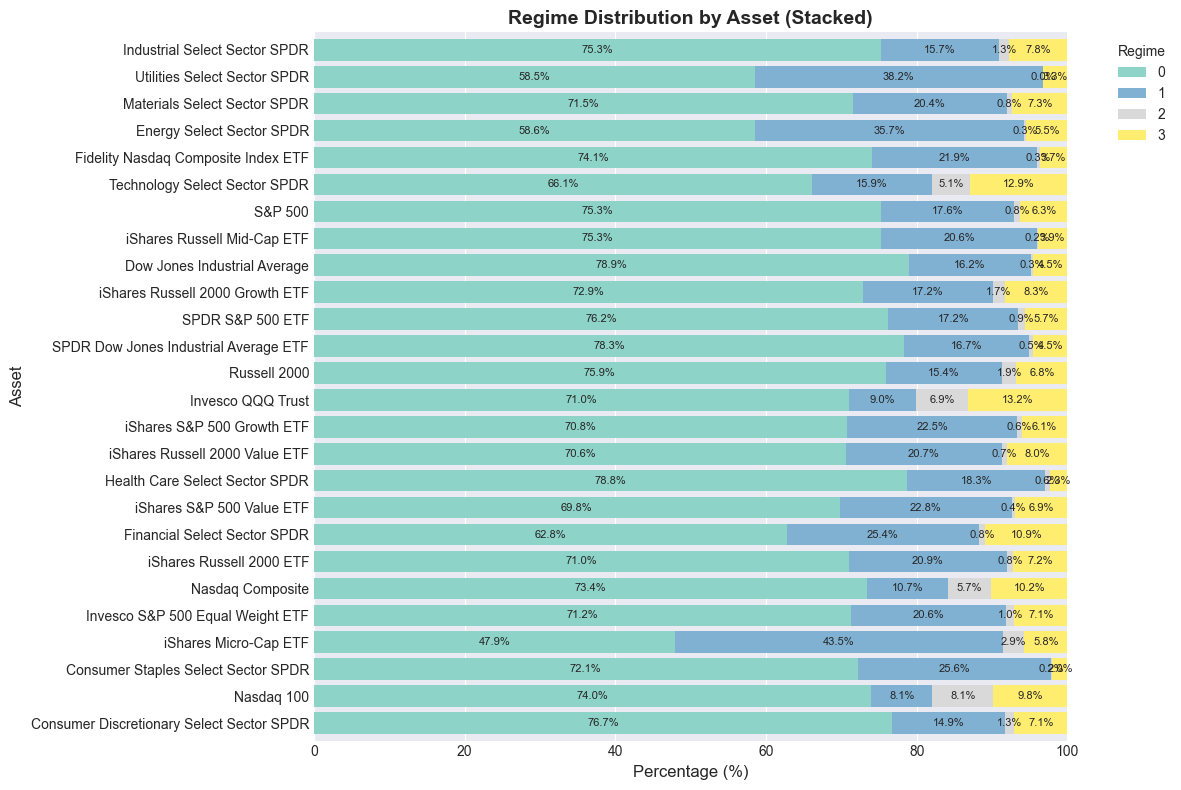

In [ ]:
# Stacked bar chart of regime distributions
regime_pct_data = metadata_df[['Asset'] + regime_pct_cols].set_index('Asset')
regime_pct_data.columns = [col.replace('Regime_', '').replace('_Pct', '') for col in regime_pct_data.columns]

ax = regime_pct_data.plot.barh(stacked=True, figsize=(12, max(8, len(models)*0.3)), 
                                colormap='Set3', width=0.8)
ax.set_xlabel('Percentage (%)', fontsize=12)
ax.set_ylabel('Asset', fontsize=12)
ax.set_title('Regime Distribution by Asset (Stacked)', fontsize=14, fontweight='bold')
ax.legend(title='Regime', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(0, 100)

# Add percentage labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center', fontsize=8)

plt.tight_layout()
plt.show()

Regime Diversity Scores:
(0 = Perfectly balanced, 1 = Completely concentrated)



,Asset,Regime_Diversity_Score,Regime_0_Pct,Regime_1_Pct,Regime_2_Pct,Regime_3_Pct
9,Health Care Select Sector SPDR,0.5538,78.7706,18.2511,0.6407,2.3377
17,Dow Jones Industrial Average,0.5375,78.9160,16.2233,0.3357,4.5251
14,SPDR Dow Jones Industrial Average ETF,0.5261,78.2992,16.6583,0.4993,4.5432
18,iShares Russell Mid-Cap ETF,0.5124,75.3024,20.6399,0.1561,3.9017
2,Consumer Staples Select Sector SPDR,0.5116,72.1385,25.6277,0.2424,1.9913
21,Fidelity Nasdaq Composite Index ETF,0.4997,74.0822,21.9406,0.2841,3.6932
15,SPDR S&P 500 ETF,0.4850,76.2285,17.2195,0.8672,5.6848
0,Consumer Discretionary Select Sector SPDR,0.4735,76.7446,14.9091,1.2814,7.0649
19,S&P 500,0.4720,75.2984,17.6405,0.8081,6.2531
13,Russell 2000,0.4548,75.8826,15.4152,1.9020,6.8001


<Figure size 1000x780 with 0 Axes>

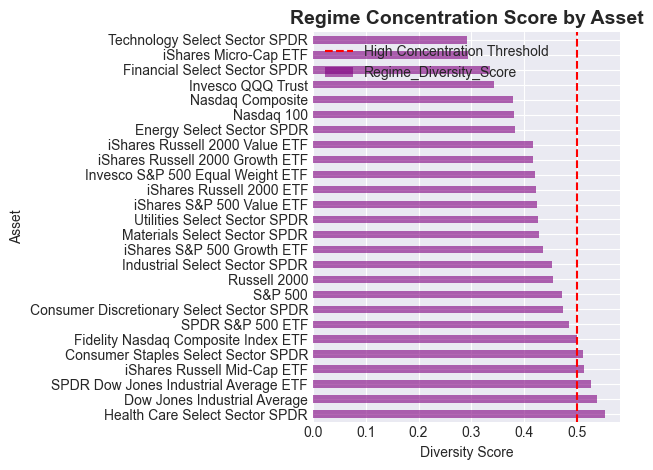

In [ ]:
# Regime diversity metric (entropy-based)
from scipy.stats import entropy

def regime_diversity_score(pcts):
    """Calculate normalized entropy as diversity score (0=uniform, 1=concentrated)"""
    pcts_normalized = np.array(pcts) / 100.0
    max_entropy = np.log(len(pcts))
    return 1 - (entropy(pcts_normalized) / max_entropy) if max_entropy > 0 else 0

metadata_df['Regime_Diversity_Score'] = metadata_df.apply(
    lambda row: regime_diversity_score([row[col] for col in regime_pct_cols]), axis=1
)

print("Regime Diversity Scores:")
print("="*80)
print("(0 = Perfectly balanced, 1 = Completely concentrated)\n")

diversity_sorted = metadata_df[['Asset', 'Regime_Diversity_Score'] + regime_pct_cols].sort_values('Regime_Diversity_Score', ascending=False)
display(diversity_sorted)

# Visualize
plt.figure(figsize=(10, max(6, len(models)*0.3)))
diversity_sorted.plot.barh(x='Asset', y='Regime_Diversity_Score', 
                           color='purple', alpha=0.6, legend=False)
plt.axvline(0.5, color='red', linestyle='--', label='High Concentration Threshold')
plt.xlabel('Diversity Score')
plt.ylabel('Asset')
plt.title('Regime Concentration Score by Asset', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Regime Duration Analysis

In [ ]:
def extract_regime_duration_stats(models: Dict) -> pd.DataFrame:
    """
    Extract regime duration statistics from all models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Regime duration statistics for all models
    """
    duration_stats = []
    
    for asset_name, model in models.items():
        try:
            regime_labels = model.regime_labels.dropna()
            
            # Calculate regime durations
            regime_changes = regime_labels != regime_labels.shift(1)
            regime_blocks = regime_changes.cumsum()
            
            durations = regime_labels.groupby(regime_blocks).size()
            
            stats = {
                'Asset': asset_name,
                'Mean_Duration': durations.mean(),
                'Median_Duration': durations.median(),
                'Std_Duration': durations.std(),
                'Min_Duration': durations.min(),
                'Max_Duration': durations.max(),
                'Q25_Duration': durations.quantile(0.25),
                'Q75_Duration': durations.quantile(0.75),
                'N_Regimes': len(durations),
                'Pct_Single_Period': (durations == 1).sum() / len(durations) * 100
            }
            
            duration_stats.append(stats)
            
        except Exception as e:
            print(f"❌ Error extracting duration stats for {asset_name}: {str(e)}")
    
    return pd.DataFrame(duration_stats)

duration_df = extract_regime_duration_stats(models)

print("Regime Duration Statistics:")
print("="*80)
display(duration_df.sort_values('Mean_Duration', ascending=False))

Regime Duration Statistics:


,Asset,Mean_Duration,Median_Duration,Std_Duration,Min_Duration,Max_Duration,Q25_Duration,Q75_Duration,N_Regimes,Pct_Single_Period
16,iShares Russell 2000 Growth ETF,94.0351,29.0,185.5485,1,961,12.00,87.00,57,1.7544
1,Nasdaq 100,87.3370,28.0,150.4820,1,999,10.00,96.75,92,3.2609
19,S&P 500,86.4409,16.0,194.0686,1,1097,6.00,64.00,93,7.5269
14,SPDR Dow Jones Industrial Average ETF,82.2055,26.0,152.0491,1,955,6.00,76.00,73,4.1096
15,SPDR S&P 500 ETF,78.1398,18.0,156.0300,1,822,8.00,47.00,93,3.2258
22,Energy Select Sector SPDR,77.8784,22.0,141.4391,1,981,5.25,89.00,74,5.4054
18,iShares Russell Mid-Cap ETF,77.5909,26.0,119.2696,1,481,6.00,82.00,66,9.0909
5,Nasdaq Composite,75.8396,25.5,140.4731,1,932,11.25,71.50,106,1.8868
25,Industrial Select Sector SPDR,74.9351,23.0,145.9268,1,786,7.00,57.00,77,2.5974
21,Fidelity Nasdaq Composite Index ETF,72.4444,27.0,123.8657,1,671,11.00,79.00,63,1.5873


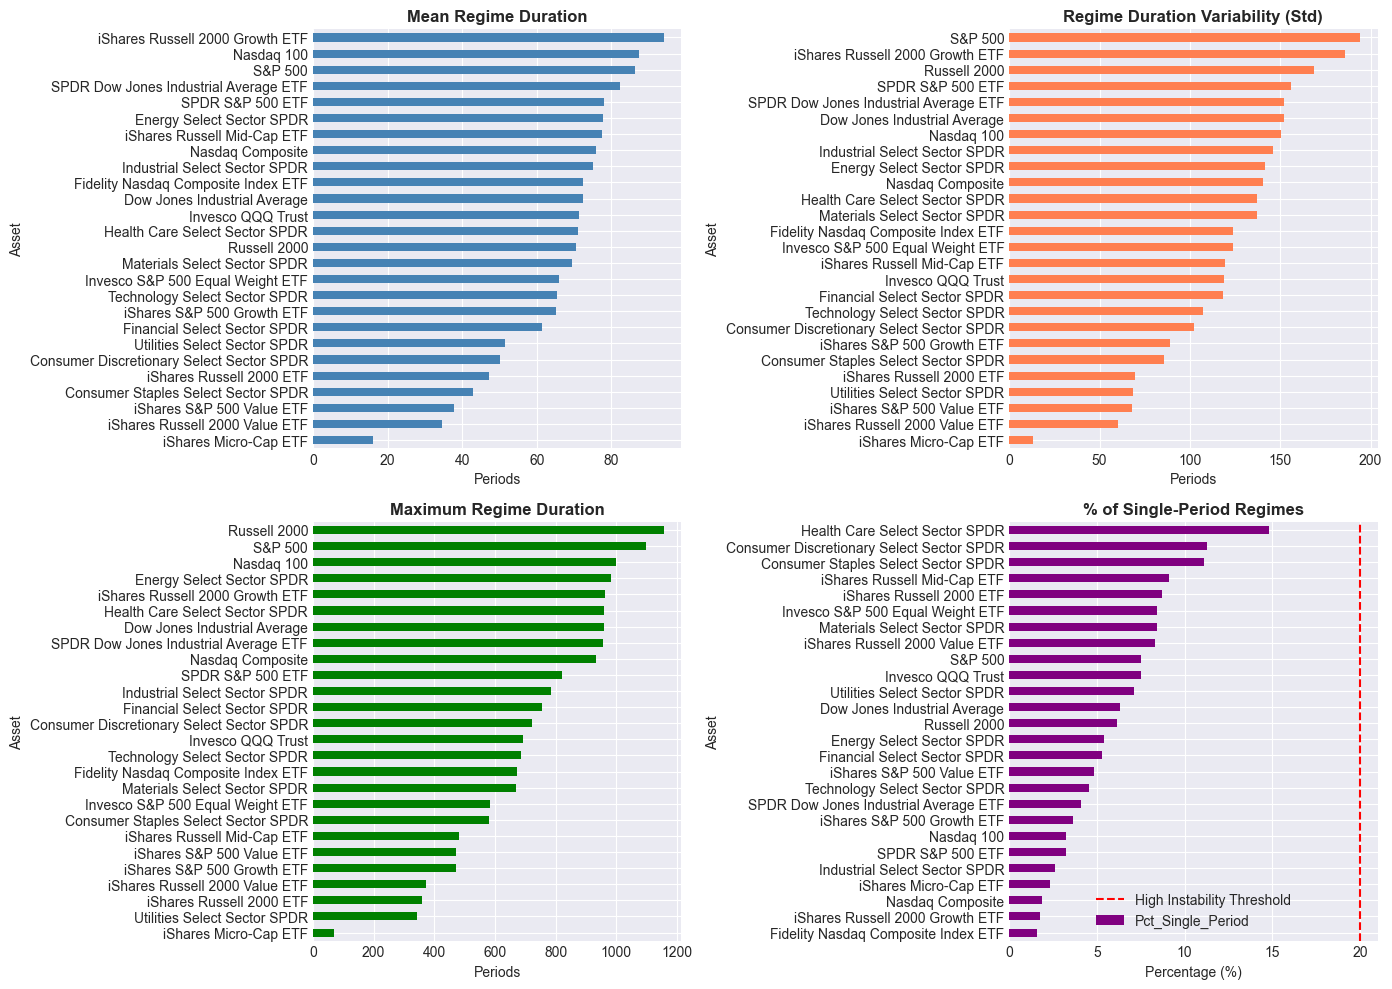

In [ ]:
# Visualize regime duration characteristics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean duration
duration_df.sort_values('Mean_Duration').plot.barh(x='Asset', y='Mean_Duration', 
                                                     ax=axes[0,0], color='steelblue', legend=False)
axes[0,0].set_title('Mean Regime Duration', fontweight='bold')
axes[0,0].set_xlabel('Periods')

# Duration variability (std)
duration_df.sort_values('Std_Duration').plot.barh(x='Asset', y='Std_Duration', 
                                                    ax=axes[0,1], color='coral', legend=False)
axes[0,1].set_title('Regime Duration Variability (Std)', fontweight='bold')
axes[0,1].set_xlabel('Periods')

# Max duration
duration_df.sort_values('Max_Duration').plot.barh(x='Asset', y='Max_Duration', 
                                                    ax=axes[1,0], color='green', legend=False)
axes[1,0].set_title('Maximum Regime Duration', fontweight='bold')
axes[1,0].set_xlabel('Periods')

# Percentage of single-period regimes
duration_df.sort_values('Pct_Single_Period').plot.barh(x='Asset', y='Pct_Single_Period', 
                                                         ax=axes[1,1], color='purple', legend=False)
axes[1,1].set_title('% of Single-Period Regimes', fontweight='bold')
axes[1,1].set_xlabel('Percentage (%)')
axes[1,1].axvline(20, color='red', linestyle='--', label='High Instability Threshold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Identify problematic duration patterns
print("Assets with Regime Duration Issues:")
print("="*80)

print("\n1. HIGH REGIME INSTABILITY (>20% single-period regimes):")
unstable = duration_df[duration_df['Pct_Single_Period'] > 20].sort_values('Pct_Single_Period', ascending=False)
if len(unstable) > 0:
    display(unstable[['Asset', 'Pct_Single_Period', 'Mean_Duration', 'N_Regimes']])
else:
    print("  ✓ None found")

print("\n2. VERY SHORT AVERAGE DURATIONS (<5 periods):")
short_duration = duration_df[duration_df['Mean_Duration'] < 5].sort_values('Mean_Duration')
if len(short_duration) > 0:
    display(short_duration[['Asset', 'Mean_Duration', 'Median_Duration', 'Pct_Single_Period']])
else:
    print("  ✓ None found")

print("\n3. VERY LONG AVERAGE DURATIONS (>50 periods):")
long_duration = duration_df[duration_df['Mean_Duration'] > 50].sort_values('Mean_Duration', ascending=False)
if len(long_duration) > 0:
    display(long_duration[['Asset', 'Mean_Duration', 'Max_Duration', 'N_Regimes']])
else:
    print("  ✓ None found")

Assets with Regime Duration Issues:

1. HIGH REGIME INSTABILITY (>20% single-period regimes):
  ✓ None found

2. VERY SHORT AVERAGE DURATIONS (<5 periods):
  ✓ None found

3. VERY LONG AVERAGE DURATIONS (>50 periods):


,Asset,Mean_Duration,Max_Duration,N_Regimes
16,iShares Russell 2000 Growth ETF,94.0351,961,57
1,Nasdaq 100,87.3370,999,92
19,S&P 500,86.4409,1097,93
14,SPDR Dow Jones Industrial Average ETF,82.2055,955,73
15,SPDR S&P 500 ETF,78.1398,822,93
22,Energy Select Sector SPDR,77.8784,981,74
18,iShares Russell Mid-Cap ETF,77.5909,481,66
5,Nasdaq Composite,75.8396,932,106
25,Industrial Select Sector SPDR,74.9351,786,77
21,Fidelity Nasdaq Composite Index ETF,72.4444,671,63


## 8. Transition Probability Comparison

In [ ]:
# Extract transition probability columns
trans_prob_cols = [col for col in metadata_df.columns if col.startswith('Trans_P_')]

print("Transition Probability Summary:")
print("="*80)
display(metadata_df[['Asset'] + trans_prob_cols].describe())

# Calculate average transition probabilities
print("\n\nAverage Transition Probabilities Across All Assets:")
avg_trans_probs = metadata_df[trans_prob_cols].mean()
for col in trans_prob_cols:
    from_regime = col.split('_')[2]
    to_regime = col.split('_')[4]
    print(f"  P({from_regime} → {to_regime}): {avg_trans_probs[col]:.4f}")

Transition Probability Summary:


,Trans_P_0_to_0,Trans_P_0_to_1,Trans_P_1_to_0,Trans_P_1_to_1
count,26.0000,26.0000,26.0000,26.0000
mean,0.9946,0.0054,0.0693,0.9307
std,0.0011,0.0011,0.0361,0.0361
min,0.9920,0.0040,0.0248,0.8215
25%,0.9937,0.0047,0.0438,0.9164
50%,0.9947,0.0053,0.0628,0.9372
75%,0.9953,0.0063,0.0836,0.9562
max,0.9960,0.0080,0.1785,0.9752




Average Transition Probabilities Across All Assets:
  P(0 → 0): 0.9946
  P(0 → 1): 0.0054
  P(1 → 0): 0.0693
  P(1 → 1): 0.9307


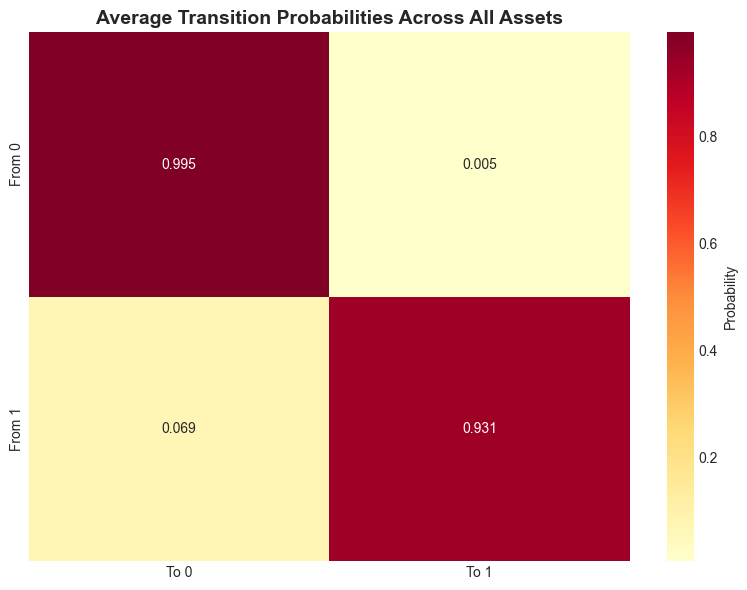

In [ ]:
# Heatmap of average transition probabilities
n_msr_regimes = models[list(models.keys())[0]].msr.n_regimes

avg_trans_matrix = np.zeros((n_msr_regimes, n_msr_regimes))

for i in range(n_msr_regimes):
    for j in range(n_msr_regimes):
        col_name = f'Trans_P_{i}_to_{j}'
        avg_trans_matrix[i, j] = metadata_df[col_name].mean()

plt.figure(figsize=(8, 6))
sns.heatmap(avg_trans_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=[f'To {i}' for i in range(n_msr_regimes)],
            yticklabels=[f'From {i}' for i in range(n_msr_regimes)],
            cbar_kws={'label': 'Probability'})
plt.title('Average Transition Probabilities Across All Assets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Identify assets with unusual transition probabilities
print("Assets with Unusual Transition Probabilities:")
print("="*80)

# Calculate persistence (diagonal probabilities)
for i in range(n_msr_regimes):
    col_name = f'Trans_P_{i}_to_{i}'
    metadata_df[f'Persistence_{i}'] = metadata_df[col_name]

persistence_cols = [f'Persistence_{i}' for i in range(n_msr_regimes)]

print("\nPersistence Probabilities (P(stay in same regime)):")
display(metadata_df[['Asset'] + persistence_cols].sort_values(persistence_cols[0]))

# Very low persistence (< 0.8)
print("\n\nAssets with LOW PERSISTENCE (<0.8):")
for i, col in enumerate(persistence_cols):
    low_persist = metadata_df[metadata_df[col] < 0.8][['Asset', col]]
    if len(low_persist) > 0:
        print(f"\nRegime {i}:")
        display(low_persist.sort_values(col))

Assets with Unusual Transition Probabilities:

Persistence Probabilities (P(stay in same regime)):


,Asset,Persistence_0,Persistence_1
7,Financial Select Sector SPDR,0.9920,0.9426
20,Technology Select Sector SPDR,0.9928,0.9672
0,Consumer Discretionary Select Sector SPDR,0.9931,0.9307
1,Nasdaq 100,0.9933,0.9693
5,Nasdaq Composite,0.9936,0.9673
23,Materials Select Sector SPDR,0.9936,0.9339
11,iShares S&P 500 Growth ETF,0.9937,0.9205
12,Invesco QQQ Trust,0.9940,0.9752
9,Health Care Select Sector SPDR,0.9942,0.8487
22,Energy Select Sector SPDR,0.9944,0.9181




Assets with LOW PERSISTENCE (<0.8):


## 9. Return Characteristics by Regime

In [ ]:
def calculate_regime_return_characteristics(models: Dict) -> pd.DataFrame:
    """
    Calculate return statistics for each regime across all models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Return characteristics by regime for all assets
    """
    regime_stats = []
    
    for asset_name, model in models.items():
        try:
            returns = model.returns.dropna()
            regime_labels = model.regime_labels.dropna()
            
            # Align on common index
            common_idx = returns.index.intersection(regime_labels.index)
            returns_aligned = returns.loc[common_idx]
            regime_labels_aligned = regime_labels.loc[common_idx]
            
            for regime in regime_labels_aligned.unique():
                if pd.isna(regime):
                    continue
                
                regime_mask = regime_labels_aligned == regime
                regime_returns = returns_aligned[regime_mask]
                
                if len(regime_returns) > 0:
                    stats = {
                        'Asset': asset_name,
                        'Regime': int(regime),
                        'N_Obs': len(regime_returns),
                        'Mean': regime_returns.mean(),
                        'Std': regime_returns.std(),
                        'Sharpe': regime_returns.mean() / regime_returns.std() * np.sqrt(252) if regime_returns.std() > 0 else 0,
                        'Skewness': skew(regime_returns),
                        'Kurtosis': kurtosis(regime_returns),
                        'Min': regime_returns.min(),
                        'Max': regime_returns.max(),
                        'Pct_Positive': (regime_returns > 0).sum() / len(regime_returns) * 100
                    }
                    
                    regime_stats.append(stats)
        
        except Exception as e:
            print(f"❌ Error calculating return characteristics for {asset_name}: {str(e)}")
    
    return pd.DataFrame(regime_stats)

regime_returns_df = calculate_regime_return_characteristics(models)
regime_returns_df['Mean'] *= 252  # Annualize mean returns
regime_returns_df['Std'] *= np.sqrt(252)  # Annualize std dev

print("Regime Return Characteristics:")
print("="*80)
display(regime_returns_df.groupby('Regime')[['Mean', 'Std', 'Sharpe', 'Skewness', 'Kurtosis']].describe())


Regime Return Characteristics:


Mean                                                           Std                                          \
       count    mean     std     min     25%     50%     75%     max count    mean     std     min     25%     50%   
Regime                                                                                                               
0       26.0  0.1139  0.0507  0.0401  0.0833  0.1020  0.1253  0.2465  26.0  0.1522  0.0244  0.1148  0.1313  0.1522   
1       26.0  0.2426  0.0987  0.0855  0.1631  0.2359  0.2906  0.4651  26.0  0.2097  0.0197  0.1761  0.1924  0.2104   
2       26.0 -3.1702  2.0361 -8.1988 -4.0231 -2.7632 -2.0367 -0.0794  26.0  0.4512  0.0847  0.1689  0.4089  0.4519   
3       26.0 -0.4208  0.3219 -1.1841 -0.5900 -0.3185 -0.1966  0.0756  26.0  0.5718  0.0951  0.4659  0.5099  0.5448   

                       Sharpe                                                          Skewness                  \
           75%     max  count    mean     std      min     25%     50%     75%     max    count    mean     std   
Regime                                                                                                            
0       0.1636  0.2255   26.0  0.7526  0.3152   0.3326  0.5400  0.6873  0.9443  1.4860     26.0 -0.3058  0.1109   
1       0.2292  0.2403   26.0  1.1641  0.4857   0.3605  0.7748  1.0984  1.5142  2.2290     26.0 -0.0530  0.0601   
2       0.4872  0.6294   26.0 -8.1969  9.2458 -48.5461 -9.0403 -5.6585 -4.5464 -0.1747     26.0  0.2778  0.5177   
3       0.5981  0.8413   26.0 -0.7078  0.4805  -1.8166 -1.0081 -0.5939 -0.3748  0.1369     26.0 -0.0063  0.2421   

                                               Kurtosis                                                           
           min     25%     50%     75%     max    count    mean     std     min     25%     50%     75%      max  
Regime                                                                                                            
0      -0.5116 -0.3610 -0.3150 -0.2233 -0.0784     26.0  1.2943  0.3764  0.4460  1.1067  1.3527  1.6070   1.8023  
1      -0.1837 -0.0795 -0.0509 -0.0231  0.1078     26.0  0.2007  0.2134 -0.1975  0.1152  0.1965  0.2828   0.8075  
2      -0.2827 -0.0438  0.1277  0.5032  2.2341     26.0  0.1683  0.9217 -0.8527 -0.2546 -0.0310  0.2677   3.8056  
3      -0.3689 -0.1697 -0.0013  0.1213  0.4967     26.0  1.3640  2.5396 -0.3705  0.5133  0.9372  1.3370  13.5591

In [ ]:
regime_returns_df

,Asset,Regime,N_Obs,Mean,Std,Sharpe,Skewness,Kurtosis,Min,Max,Pct_Positive
0,Consumer Discretionary Select Sector SPDR,0,4283,0.1102,0.1549,0.7118,-0.3158,1.3860,-0.0441,0.0459,53.4672
1,Consumer Discretionary Select Sector SPDR,1,1013,0.2105,0.2367,0.8891,-0.0062,-0.1447,-0.0432,0.0473,52.1224
2,Consumer Discretionary Select Sector SPDR,3,421,-0.0003,0.5280,-0.0006,-0.2463,0.7695,-0.1355,0.0933,49.1686
3,Consumer Discretionary Select Sector SPDR,2,61,-2.7400,0.4054,-6.7582,-0.0493,-0.1162,-0.0826,0.0509,32.7869
4,Nasdaq 100,1,678,0.4651,0.2087,2.2290,0.0332,0.2358,-0.0370,0.0404,58.4071
...,...,...,...,...,...,...,...,...,...,...,...
99,Utilities Select Sector SPDR,2,6,-8.1988,0.1689,-48.5461,0.5176,-0.5082,-0.0460,-0.0149,0.0000
100,Industrial Select Sector SPDR,0,4327,0.0935,0.1518,0.6157,-0.2783,1.1812,-0.0416,0.0390,53.5937
101,Industrial Select Sector SPDR,1,921,0.2328,0.2184,1.0657,-0.1697,0.1308,-0.0453,0.0406,53.6374
102,Industrial Select Sector SPDR,3,445,-0.1835,0.5092,-0.3603,-0.1316,0.9527,-0.1204,0.1191,50.3371


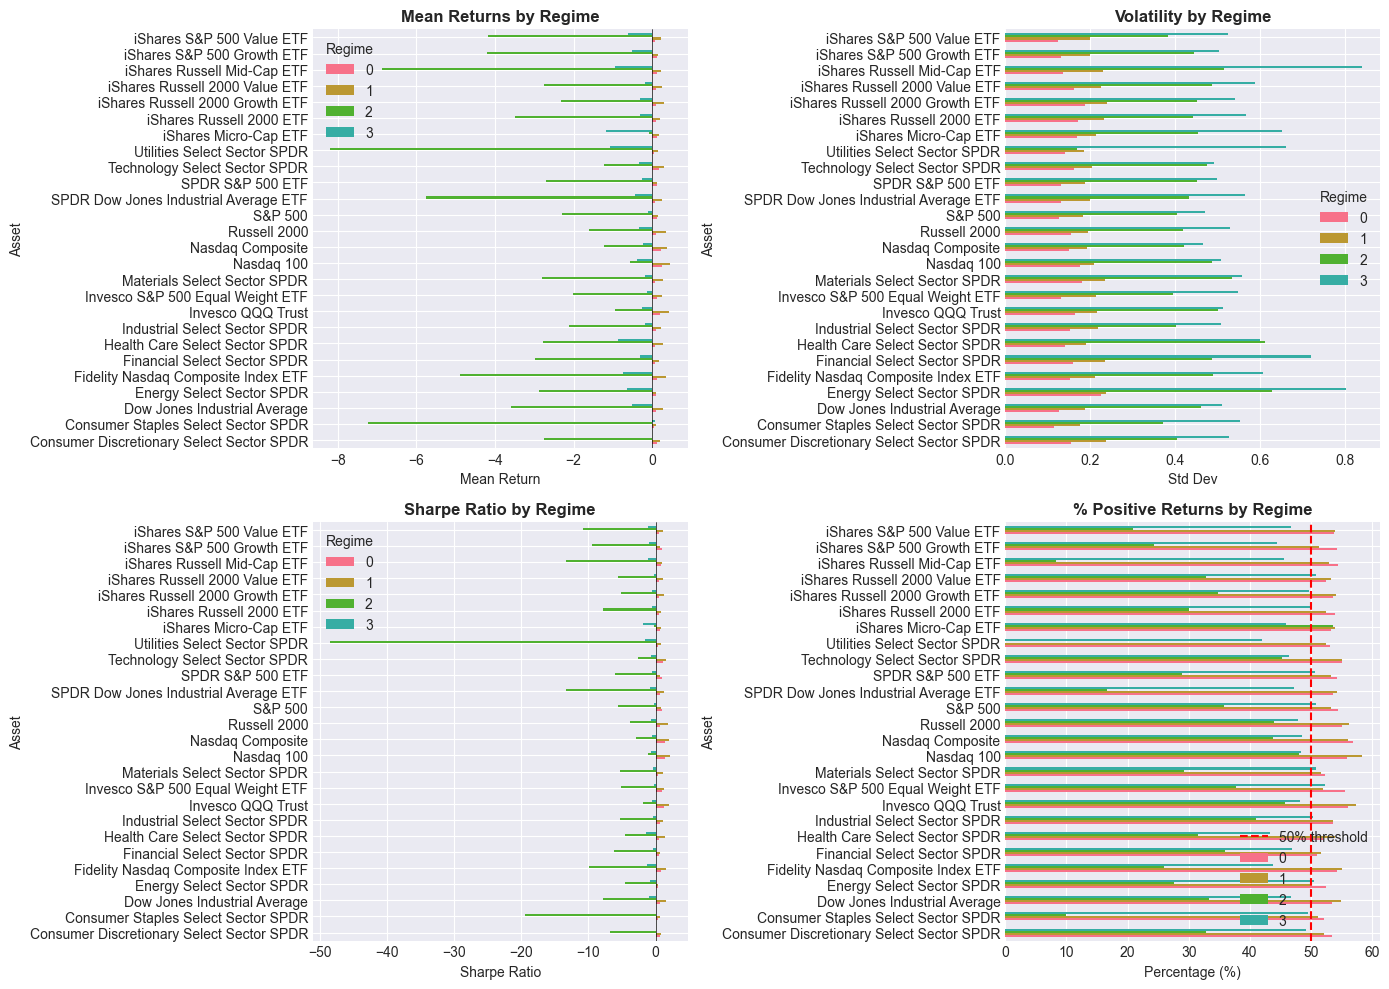

In [ ]:
# Compare return characteristics across regimes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Mean returns by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Mean').plot.barh(ax=axes[0,0])
axes[0,0].set_title('Mean Returns by Regime', fontweight='bold')
axes[0,0].set_xlabel('Mean Return')
axes[0,0].axvline(0, color='black', linestyle='-', linewidth=0.5)

# Volatility by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Std').plot.barh(ax=axes[0,1])
axes[0,1].set_title('Volatility by Regime', fontweight='bold')
axes[0,1].set_xlabel('Std Dev')

# Sharpe ratio by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Sharpe').plot.barh(ax=axes[1,0])
axes[1,0].set_title('Sharpe Ratio by Regime', fontweight='bold')
axes[1,0].set_xlabel('Sharpe Ratio')
axes[1,0].axvline(0, color='black', linestyle='-', linewidth=0.5)

# Percentage positive by regime
regime_returns_df.pivot(index='Asset', columns='Regime', values='Pct_Positive').plot.barh(ax=axes[1,1])
axes[1,1].set_title('% Positive Returns by Regime', fontweight='bold')
axes[1,1].set_xlabel('Percentage (%)')
axes[1,1].axvline(50, color='red', linestyle='--', label='50% threshold')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Identify poorly differentiated regimes based on returns
print("Regime Differentiation Analysis:")
print("="*80)

for asset_name in regime_returns_df['Asset'].unique():
    asset_data = regime_returns_df[regime_returns_df['Asset'] == asset_name]
    
    if len(asset_data) >= 2:
        # Check if regimes have similar returns
        mean_diff = abs(asset_data['Mean'].max() - asset_data['Mean'].min())
        std_diff = abs(asset_data['Std'].max() - asset_data['Std'].min())
        
        # Flag if differences are small
        if mean_diff < 0.0005:  # Very small mean difference
            print(f"\n⚠️  {asset_name}: WEAK Mean Differentiation")
            print(f"   Mean difference: {mean_diff:.6f}")
            display(asset_data[['Regime', 'Mean', 'Std', 'Sharpe']])

Regime Differentiation Analysis:


## 10. Model Performance Metrics

In [ ]:
def calculate_model_performance_metrics(models: Dict) -> pd.DataFrame:
    """
    Calculate performance metrics for all models.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Performance metrics for all models
    """
    performance_metrics = []
    
    for asset_name, model in models.items():
        try:
            returns = model.returns.dropna()
            regime_labels = model.regime_labels.dropna()
            
            # Align returns and regime_labels on common index
            common_idx = returns.index.intersection(regime_labels.index)
            returns_aligned = returns.loc[common_idx]
            regime_labels_aligned = regime_labels.loc[common_idx]
            
            # Number of parameters
            n_regimes = model.msr.n_regimes
            n_params = n_regimes * 3 + n_regimes * (n_regimes - 1)  # means, stds, betas, transition probs
            
            # Log-likelihood (approximate)
            log_likelihood = 0
            for regime in range(n_regimes):
                regime_mask = regime_labels_aligned == regime
                regime_returns = returns_aligned[regime_mask]
                if len(regime_returns) > 0:
                    ll = -0.5 * len(regime_returns) * np.log(2 * np.pi * model.msr.stds[regime]**2)
                    ll -= np.sum((regime_returns - model.msr.means[regime])**2) / (2 * model.msr.stds[regime]**2)
                    log_likelihood += ll
            
            # AIC and BIC
            n_obs = len(returns_aligned)
            aic = 2 * n_params - 2 * log_likelihood
            bic = n_params * np.log(n_obs) - 2 * log_likelihood
            
            metrics = {
                'Asset': asset_name,
                'Log_Likelihood': log_likelihood,
                'AIC': aic,
                'BIC': bic,
                'N_Params': n_params,
                'N_Obs': n_obs,
                'AIC_per_Obs': aic / n_obs,
                'BIC_per_Obs': bic / n_obs
            }
            
            performance_metrics.append(metrics)
            
        except Exception as e:
            print(f"❌ Error calculating performance metrics for {asset_name}: {str(e)}")
    
    return pd.DataFrame(performance_metrics)

performance_df = calculate_model_performance_metrics(models)

print("Model Performance Metrics:")
print("="*80)
if len(performance_df) > 0:
    display(performance_df.sort_values('BIC'))
else:
    print("❌ No performance metrics calculated")


Model Performance Metrics:


,Asset,Log_Likelihood,AIC,BIC,N_Params,N_Obs,AIC_per_Obs,BIC_per_Obs
17,Dow Jones Industrial Average,24381.2530,-48746.5060,-48690.5705,8,8038,-6.0645,-6.0575
19,S&P 500,23903.5467,-47791.0935,-47735.1560,8,8040,-5.9442,-5.9372
13,Russell 2000,22247.6126,-44479.2252,-44423.2947,8,8033,-5.5371,-5.5301
15,SPDR S&P 500 ETF,21371.9890,-42727.9781,-42672.8482,8,7268,-5.8789,-5.8713
5,Nasdaq Composite,21110.7083,-42205.4167,-42149.4792,8,8040,-5.2494,-5.2425
1,Nasdaq 100,19754.4545,-39492.9091,-39436.9756,8,8036,-4.9145,-4.9075
14,SPDR Dow Jones Industrial Average ETF,17602.3121,-35188.6242,-35135.0254,8,6002,-5.8628,-5.8539
2,Consumer Staples Select Sector SPDR,17281.2409,-34546.4818,-34493.1776,8,5785,-5.9717,-5.9625
9,Health Care Select Sector SPDR,16858.8000,-33701.5999,-33648.3248,8,5764,-5.8469,-5.8377
25,Industrial Select Sector SPDR,15908.4001,-31800.8001,-31747.5153,8,5771,-5.5104,-5.5012


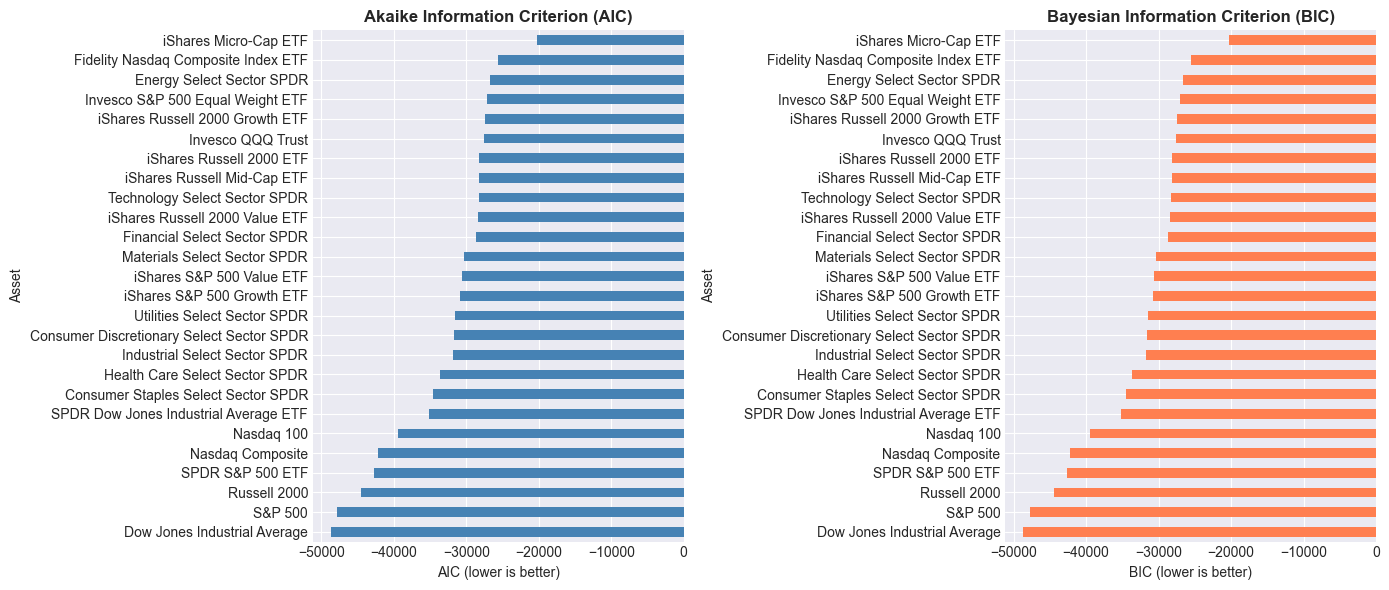


Best Performing Models (by BIC):


,Asset,Log_Likelihood,AIC,BIC
17,Dow Jones Industrial Average,24381.2530,-48746.5060,-48690.5705
19,S&P 500,23903.5467,-47791.0935,-47735.1560
13,Russell 2000,22247.6126,-44479.2252,-44423.2947
15,SPDR S&P 500 ETF,21371.9890,-42727.9781,-42672.8482
5,Nasdaq Composite,21110.7083,-42205.4167,-42149.4792



Worst Performing Models (by BIC):


,Asset,Log_Likelihood,AIC,BIC
3,iShares Micro-Cap ETF,10162.4360,-20308.8720,-20258.2929
21,Fidelity Nasdaq Composite Index ETF,12824.0165,-25632.0329,-25580.6235
22,Energy Select Sector SPDR,13355.8300,-26695.6601,-26642.3850
4,Invesco S&P 500 Equal Weight ETF,13586.8230,-27157.6461,-27106.0172
16,iShares Russell 2000 Growth ETF,13741.0461,-27466.0922,-27413.3970


In [ ]:
# Visualize performance metrics
if len(performance_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # AIC
    performance_df.sort_values('AIC').plot.barh(x='Asset', y='AIC', ax=axes[0], 
                                                 color='steelblue', legend=False)
    axes[0].set_title('Akaike Information Criterion (AIC)', fontweight='bold')
    axes[0].set_xlabel('AIC (lower is better)')

    # BIC
    performance_df.sort_values('BIC').plot.barh(x='Asset', y='BIC', ax=axes[1], 
                                                 color='coral', legend=False)
    axes[1].set_title('Bayesian Information Criterion (BIC)', fontweight='bold')
    axes[1].set_xlabel('BIC (lower is better)')

    plt.tight_layout()
    plt.show()

    print("\nBest Performing Models (by BIC):")
    display(performance_df.nsmallest(5, 'BIC')[['Asset', 'Log_Likelihood', 'AIC', 'BIC']])

    print("\nWorst Performing Models (by BIC):")
    display(performance_df.nlargest(5, 'BIC')[['Asset', 'Log_Likelihood', 'AIC', 'BIC']])
else:
    print("❌ No performance data to visualize")


## 11. Regime Stability Analysis

In [ ]:
# Combine with earlier duration metrics
stability_df = metadata_df[['Asset', 'N_Regime_Changes', 'Avg_Regime_Duration']].merge(
    duration_df[['Asset', 'Pct_Single_Period', 'Std_Duration']], 
    on='Asset'
)

# Add regime change frequency
stability_df['Changes_Per_100_Periods'] = (stability_df['N_Regime_Changes'] / 
                                           metadata_df['N_Data_Points'] * 100)

print("Regime Stability Metrics:")
print("="*80)
display(stability_df.sort_values('Changes_Per_100_Periods', ascending=False))

Regime Stability Metrics:


,Asset,N_Regime_Changes,Avg_Regime_Duration,Pct_Single_Period,Std_Duration,Changes_Per_100_Periods
3,iShares Micro-Cap ETF,255,16.0742,2.3438,13.1898,6.1833
10,iShares Russell 2000 Value ETF,155,34.5256,8.3333,60.0713,2.8746
8,iShares S&P 500 Value ETF,143,37.6875,4.8611,67.6977,2.6311
2,Consumer Staples Select Sector SPDR,134,42.8519,11.1111,85.9443,2.3123
6,iShares Russell 2000 ETF,114,47.1478,8.6957,69.5128,2.0975
0,Consumer Discretionary Select Sector SPDR,114,50.2435,11.3043,102.3424,1.9672
24,Utilities Select Sector SPDR,111,51.5982,7.1429,68.7512,1.9154
7,Financial Select Sector SPDR,93,61.3191,5.3191,118.0796,1.6048
11,iShares S&P 500 Growth ETF,82,65.2651,3.6145,89.1833,1.5087
20,Technology Select Sector SPDR,87,65.5455,4.5455,106.9744,1.5013


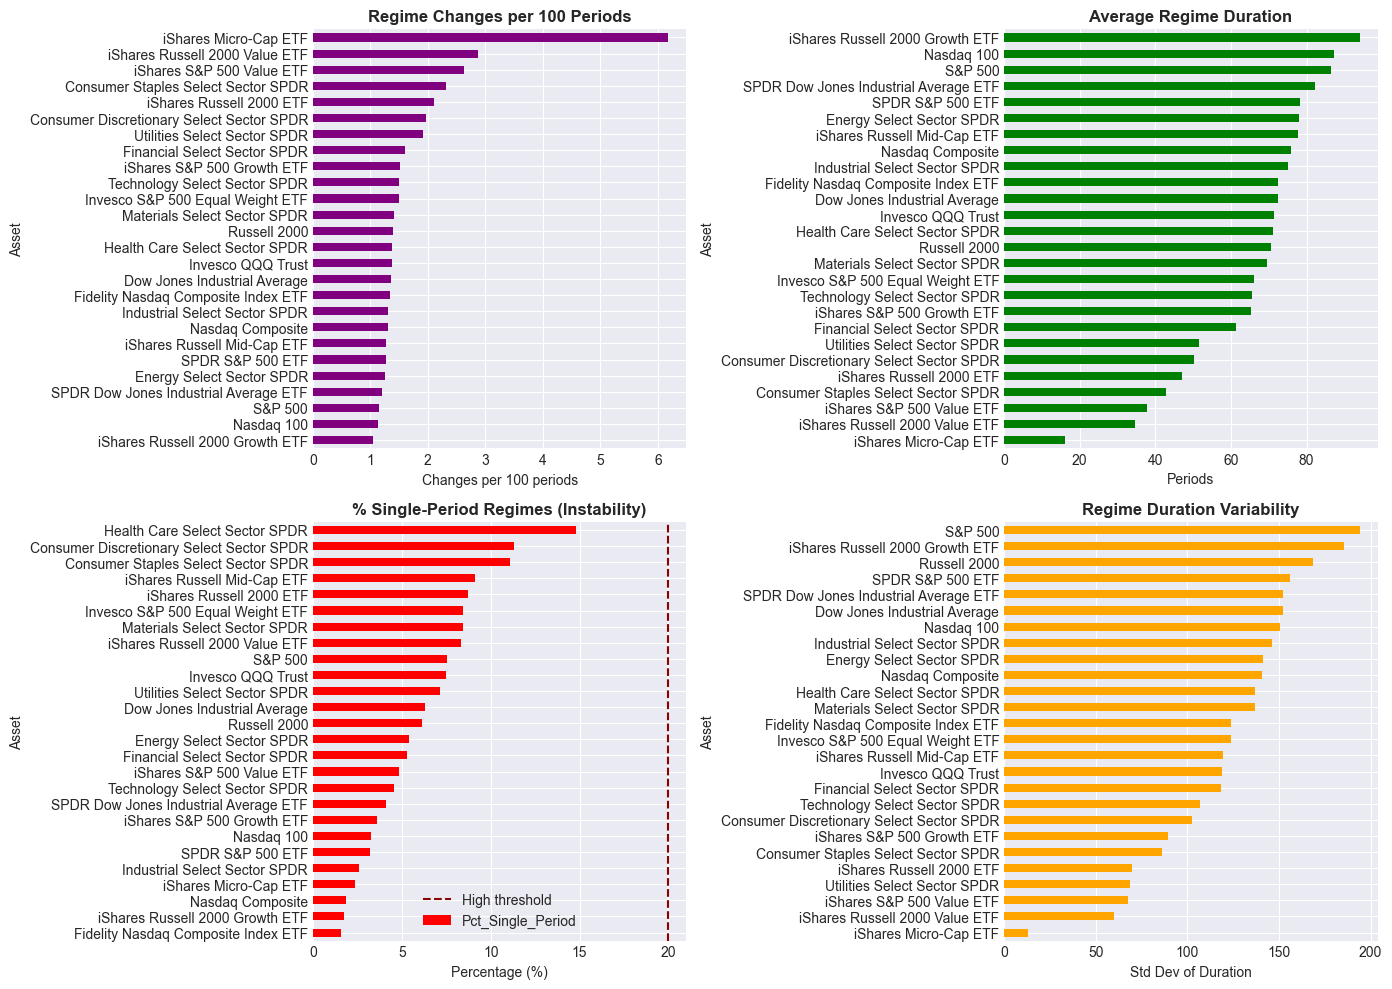

In [ ]:
# Visualize stability metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Regime changes per 100 periods
stability_df.sort_values('Changes_Per_100_Periods').plot.barh(
    x='Asset', y='Changes_Per_100_Periods', ax=axes[0,0], color='purple', legend=False
)
axes[0,0].set_title('Regime Changes per 100 Periods', fontweight='bold')
axes[0,0].set_xlabel('Changes per 100 periods')

# Average regime duration
stability_df.sort_values('Avg_Regime_Duration').plot.barh(
    x='Asset', y='Avg_Regime_Duration', ax=axes[0,1], color='green', legend=False
)
axes[0,1].set_title('Average Regime Duration', fontweight='bold')
axes[0,1].set_xlabel('Periods')

# Percentage single-period regimes
stability_df.sort_values('Pct_Single_Period').plot.barh(
    x='Asset', y='Pct_Single_Period', ax=axes[1,0], color='red', legend=False
)
axes[1,0].set_title('% Single-Period Regimes (Instability)', fontweight='bold')
axes[1,0].set_xlabel('Percentage (%)')
axes[1,0].axvline(20, color='darkred', linestyle='--', label='High threshold')
axes[1,0].legend()

# Duration variability
stability_df.sort_values('Std_Duration').plot.barh(
    x='Asset', y='Std_Duration', ax=axes[1,1], color='orange', legend=False
)
axes[1,1].set_title('Regime Duration Variability', fontweight='bold')
axes[1,1].set_xlabel('Std Dev of Duration')

plt.tight_layout()
plt.show()

In [ ]:
# Identify unstable models
print("Models with Stability Issues:")
print("="*80)

print("\n1. HIGH REGIME SWITCHING (>15 changes per 100 periods):")
high_switching = stability_df[stability_df['Changes_Per_100_Periods'] > 15].sort_values(
    'Changes_Per_100_Periods', ascending=False
)
if len(high_switching) > 0:
    display(high_switching)
else:
    print("  ✓ None found")

print("\n2. HIGH INSTABILITY (>20% single-period regimes):")
high_instability = stability_df[stability_df['Pct_Single_Period'] > 20].sort_values(
    'Pct_Single_Period', ascending=False
)
if len(high_instability) > 0:
    display(high_instability)
else:
    print("  ✓ None found")

Models with Stability Issues:

1. HIGH REGIME SWITCHING (>15 changes per 100 periods):
  ✓ None found

2. HIGH INSTABILITY (>20% single-period regimes):
  ✓ None found


## 12. Parameter Sensitivity Visualization

In [ ]:
# Merge all dataframes for comprehensive analysis
comprehensive_df = metadata_df.merge(duration_df, on='Asset', suffixes=('', '_dur'))
comprehensive_df = comprehensive_df.merge(performance_df, on='Asset')
comprehensive_df = comprehensive_df.merge(stability_df[['Asset', 'Changes_Per_100_Periods']], on='Asset')

print("Comprehensive Dataset Shape:", comprehensive_df.shape)
print("\nFirst few rows:")
display(comprehensive_df.head())

Comprehensive Dataset Shape: (26, 47)

First few rows:


,Asset,N_Data_Points,N_MSR_Regimes,N_Combined_Regimes,KAMA_n,KAMA_n_fast,KAMA_n_slow,Filter_gamma,N_Regime_Changes,Avg_Regime_Duration,Regime_0_Pct,Regime_0_Count,Regime_1_Pct,Regime_1_Count,Regime_2_Pct,Regime_2_Count,Regime_3_Pct,Regime_3_Count,MSR_Mean_0,MSR_Std_0,MSR_Beta_0,MSR_Mean_1,MSR_Std_1,MSR_Beta_1,Trans_P_0_to_0,Trans_P_0_to_1,Trans_P_1_to_0,Trans_P_1_to_1,Persistence_0,Persistence_1,Mean_Duration,Median_Duration,Std_Duration,Min_Duration,Max_Duration,Q25_Duration,Q75_Duration,N_Regimes,Pct_Single_Period,Log_Likelihood,AIC,BIC,N_Params,N_Obs,AIC_per_Obs,BIC_per_Obs,Changes_Per_100_Periods
0,Consumer Discretionary Select Sector SPDR,5795,2,4,16,10,50,0.5,114,50.2435,74.1260,4283,17.5320,1013,1.0557,61,7.2863,421,0.0005,0.0125,-0.0062,-0.0012,0.0370,-0.0170,0.9931,0.0069,0.0693,0.9307,0.9931,0.9307,50.2348,15.0,102.3424,1,721,3.00,40.50,115,11.3043,15848.2866,-31680.5732,-31627.2787,8,5778,-5.4830,-5.4737,1.9672
1,Nasdaq 100,8064,2,4,27,10,60,2.0,91,87.3478,73.6063,5915,8.4370,678,8.1010,651,9.8556,792,0.0010,0.0127,0.0036,-0.0019,0.0333,-0.0617,0.9933,0.0067,0.0307,0.9693,0.9933,0.9693,87.3370,28.0,150.4820,1,999,10.00,96.75,92,3.2609,19754.4545,-39492.9091,-39436.9756,8,8036,-4.9145,-4.9075,1.1285
2,Consumer Staples Select Sector SPDR,5795,2,4,9,10,60,0.5,134,42.8519,71.9965,4165,25.7736,1491,0.1729,10,2.0570,119,0.0002,0.0103,-0.0196,-0.0018,0.0492,-0.0189,0.9951,0.0049,0.1785,0.8215,0.9951,0.8215,42.8444,12.0,85.9443,1,579,4.00,36.00,135,11.1111,17281.2409,-34546.4818,-34493.1776,8,5785,-5.9717,-5.9625,2.3123
3,iShares Micro-Cap ETF,4124,2,4,8,2,40,2.0,255,16.0742,54.8481,2257,36.5735,1505,3.4022,140,5.1762,213,0.0005,0.0140,-0.0038,-0.0027,0.0436,-0.0531,0.9954,0.0046,0.0491,0.9509,0.9954,0.9509,16.0703,12.0,13.1898,1,69,6.75,22.00,256,2.3438,10162.4360,-20308.8720,-20258.2929,8,4115,-4.9353,-4.9230,6.1833
4,Invesco S&P 500 Equal Weight ETF,4703,2,4,10,10,50,1.0,70,66.0845,79.5183,3731,12.3615,580,0.9591,45,7.1611,336,0.0006,0.0114,-0.0053,-0.0018,0.0401,-0.0391,0.9960,0.0040,0.0427,0.9573,0.9960,0.9573,66.0704,14.0,123.6892,1,582,5.00,60.00,71,8.4507,13586.8230,-27157.6461,-27106.0172,8,4692,-5.7881,-5.7771,1.4884


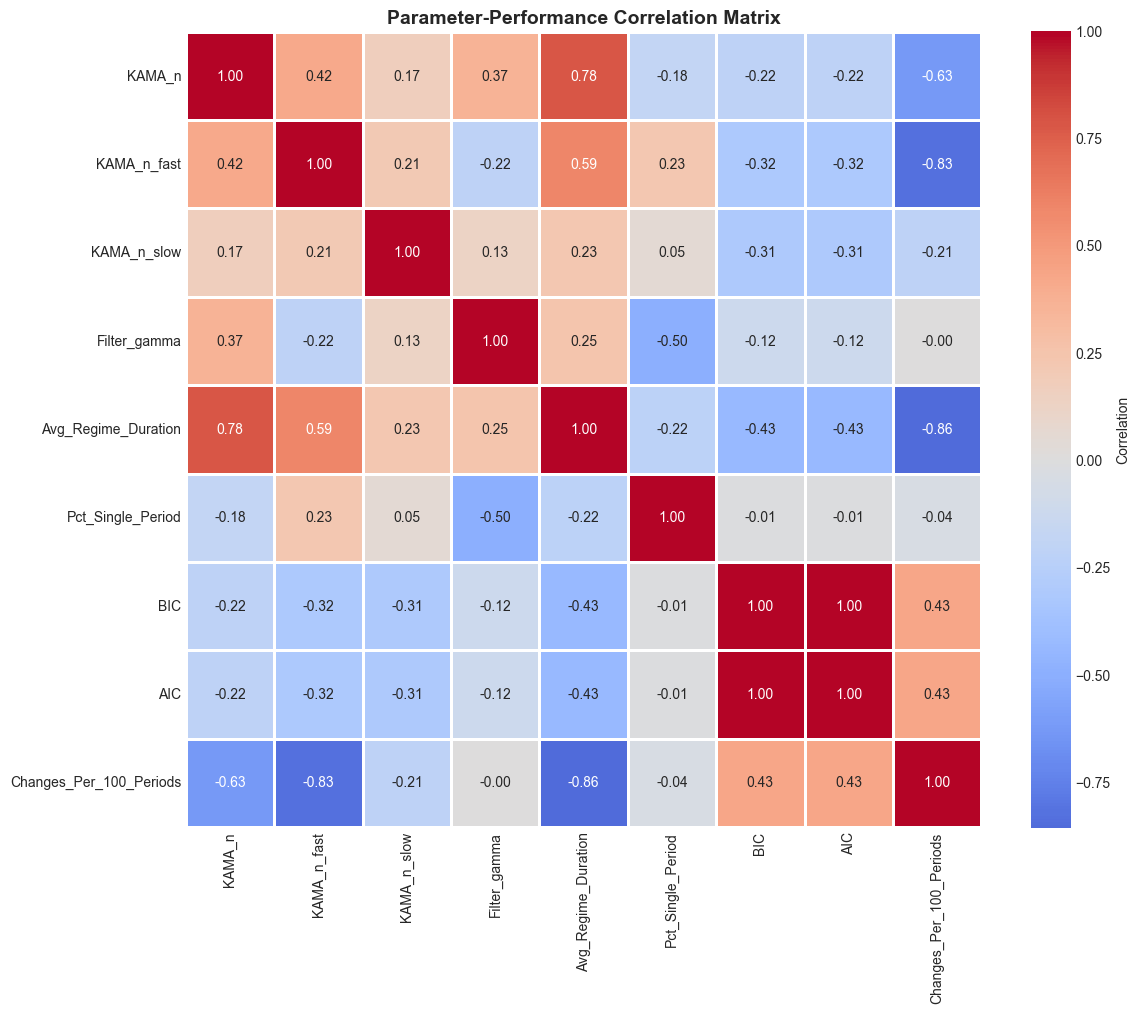


Strongest Correlations with Performance Metrics:

Correlations with BIC (model quality):
  AIC: 1.000
  Avg_Regime_Duration: -0.430
  Changes_Per_100_Periods: 0.428
  KAMA_n_fast: -0.318
  KAMA_n_slow: -0.312


In [ ]:
# Correlation matrix of key parameters and performance metrics
key_columns = [
    'KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow', 'Filter_gamma',
    'Avg_Regime_Duration', 'Pct_Single_Period',
    'BIC', 'AIC', 'Changes_Per_100_Periods',
    'Regime_Diversity_Score'
]

# Filter columns that exist
available_cols = [col for col in key_columns if col in comprehensive_df.columns]

correlation_matrix = comprehensive_df[available_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Parameter-Performance Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nStrongest Correlations with Performance Metrics:")
print("="*80)

# Find strongest correlations with BIC
if 'BIC' in correlation_matrix.columns:
    bic_corr = correlation_matrix['BIC'].drop('BIC').abs().sort_values(ascending=False)
    print("\nCorrelations with BIC (model quality):")
    for param, corr in bic_corr.head(5).items():
        print(f"  {param}: {correlation_matrix.loc[param, 'BIC']:.3f}")

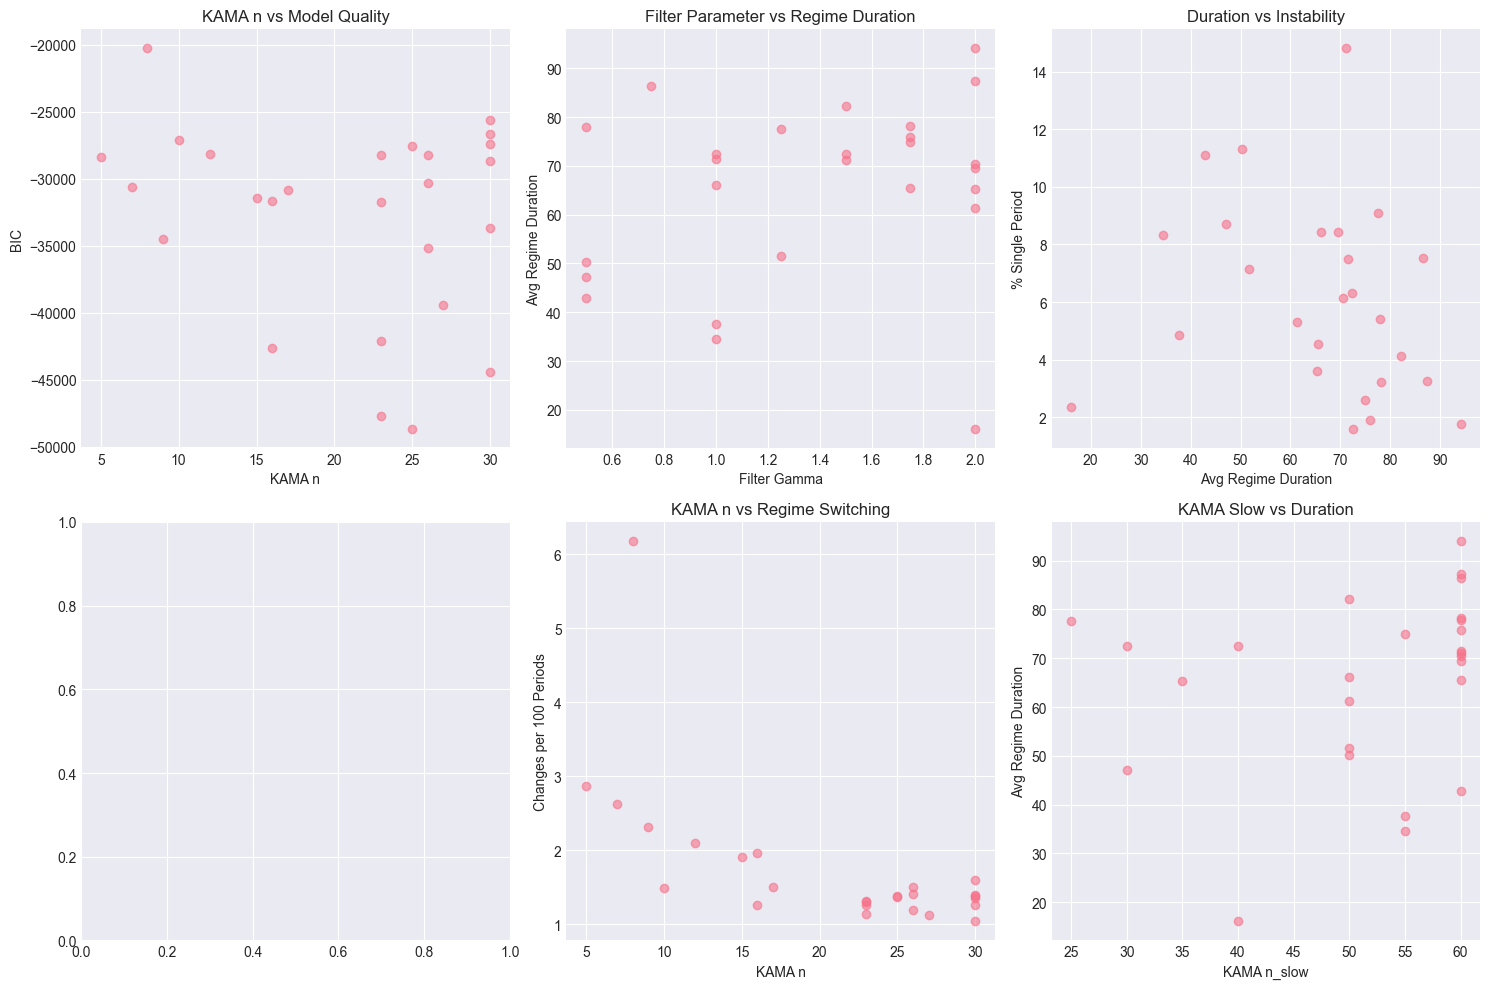

In [ ]:
# Scatter plots of key relationships
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# KAMA_n vs BIC
if 'BIC' in comprehensive_df.columns:
    axes[0,0].scatter(comprehensive_df['KAMA_n'], comprehensive_df['BIC'], alpha=0.6)
    axes[0,0].set_xlabel('KAMA n')
    axes[0,0].set_ylabel('BIC')
    axes[0,0].set_title('KAMA n vs Model Quality')

# Filter gamma vs Avg Duration
axes[0,1].scatter(comprehensive_df['Filter_gamma'], comprehensive_df['Avg_Regime_Duration'], alpha=0.6)
axes[0,1].set_xlabel('Filter Gamma')
axes[0,1].set_ylabel('Avg Regime Duration')
axes[0,1].set_title('Filter Parameter vs Regime Duration')

# Avg Duration vs Single Period %
axes[0,2].scatter(comprehensive_df['Avg_Regime_Duration'], comprehensive_df['Pct_Single_Period'], alpha=0.6)
axes[0,2].set_xlabel('Avg Regime Duration')
axes[0,2].set_ylabel('% Single Period')
axes[0,2].set_title('Duration vs Instability')

# Diversity Score vs BIC
if 'BIC' in comprehensive_df.columns and 'Regime_Diversity_Score' in comprehensive_df.columns:
    axes[1,0].scatter(comprehensive_df['Regime_Diversity_Score'], comprehensive_df['BIC'], alpha=0.6)
    axes[1,0].set_xlabel('Regime Diversity Score')
    axes[1,0].set_ylabel('BIC')
    axes[1,0].set_title('Regime Balance vs Model Quality')

# KAMA_n vs Changes per 100
axes[1,1].scatter(comprehensive_df['KAMA_n'], comprehensive_df['Changes_Per_100_Periods'], alpha=0.6)
axes[1,1].set_xlabel('KAMA n')
axes[1,1].set_ylabel('Changes per 100 Periods')
axes[1,1].set_title('KAMA n vs Regime Switching')
# KAMA n_slow vs Avg Duration
axes[1,2].scatter(comprehensive_df['KAMA_n_slow'], comprehensive_df['Avg_Regime_Duration'], alpha=0.6)
axes[1,2].set_xlabel('KAMA n_slow')
axes[1,2].set_ylabel('Avg Regime Duration')
axes[1,2].set_title('KAMA Slow vs Duration')

plt.tight_layout()
plt.show()

## 13. Cross-Asset Regime Correlation

In [ ]:
def build_regime_label_matrix(models: Dict) -> pd.DataFrame:
    """
    Build a matrix of regime labels across all assets.
    
    Parameters:
    -----------
    models : Dict
        Dictionary of loaded KAMA-MSR models
    
    Returns:
    --------
    pd.DataFrame : Matrix with dates as index and assets as columns containing regime labels
    """
    regime_data = {}
    
    for asset_name, model in models.items():
        regime_data[asset_name] = model.regime_labels
    
    regime_matrix = pd.DataFrame(regime_data)
    return regime_matrix

regime_matrix = build_regime_label_matrix(models)

print("Regime Label Matrix:")
print("="*80)
print(f"Shape: {regime_matrix.shape}")
print(f"Date range: {regime_matrix.index.min()} to {regime_matrix.index.max()}")
print("\Last few rows:")
display(regime_matrix.tail())

Regime Label Matrix:
Shape: (8063, 26)
Date range: 1990-01-03 00:00:00 to 2021-12-31 00:00:00
\Last few rows:


,Consumer Discretionary Select Sector SPDR,Nasdaq 100,Consumer Staples Select Sector SPDR,iShares Micro-Cap ETF,Invesco S&P 500 Equal Weight ETF,Nasdaq Composite,iShares Russell 2000 ETF,Financial Select Sector SPDR,iShares S&P 500 Value ETF,Health Care Select Sector SPDR,iShares Russell 2000 Value ETF,iShares S&P 500 Growth ETF,Invesco QQQ Trust,Russell 2000,SPDR Dow Jones Industrial Average ETF,SPDR S&P 500 ETF,iShares Russell 2000 Growth ETF,Dow Jones Industrial Average,iShares Russell Mid-Cap ETF,S&P 500,Technology Select Sector SPDR,Fidelity Nasdaq Composite Index ETF,Energy Select Sector SPDR,Materials Select Sector SPDR,Utilities Select Sector SPDR,Industrial Select Sector SPDR
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-27,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-28,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


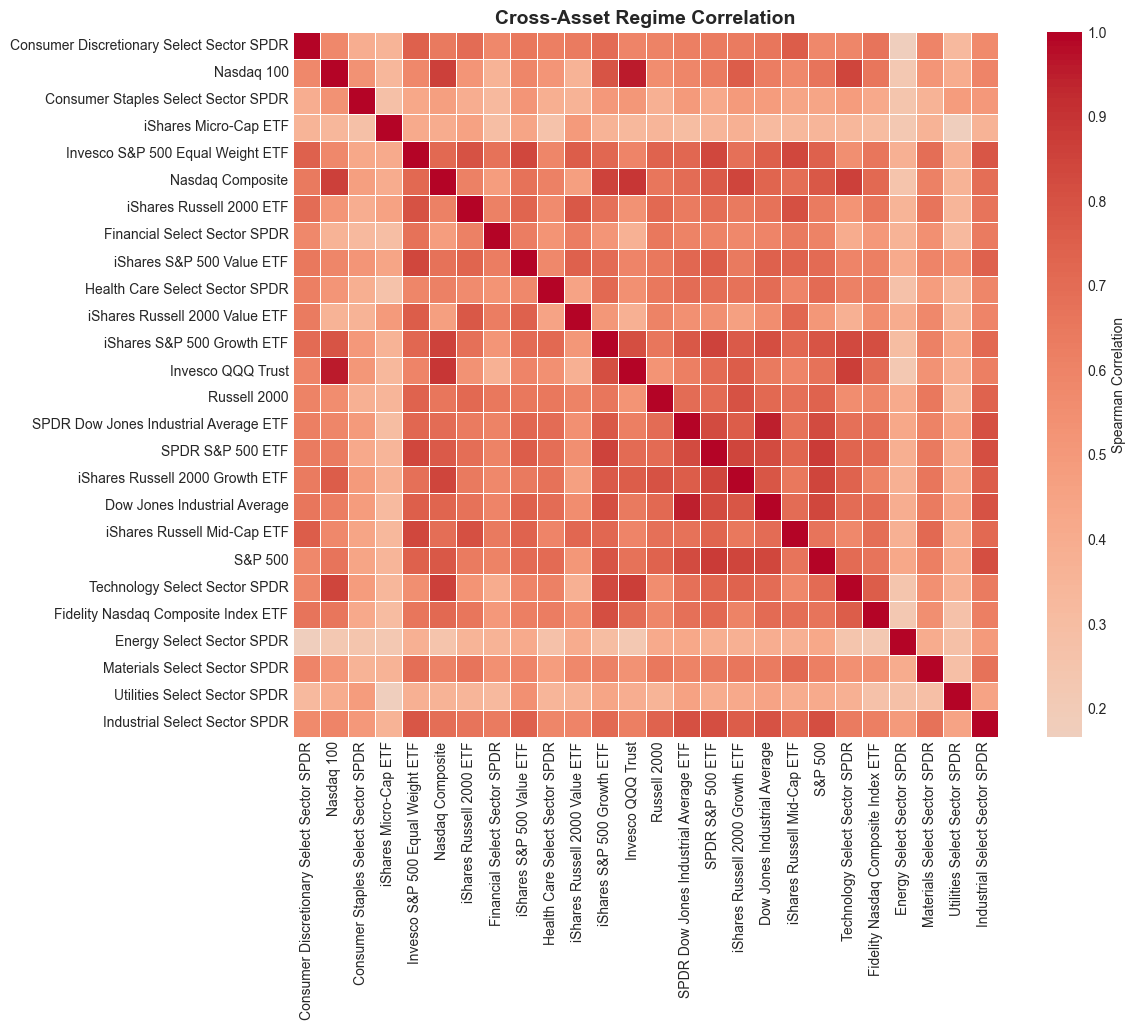


Strongest Cross-Asset Regime Correlations:

Highest Positive Correlations:


,Asset 1,Asset 2,Correlation
67,Nasdaq 100,Invesco QQQ Trust,0.9566
150,SPDR Dow Jones Industrial Average ETF,Dow Jones Industrial Average,0.9472
71,Nasdaq Composite,Invesco QQQ Trust,0.8949
186,SPDR S&P 500 ETF,S&P 500,0.8743
202,Invesco QQQ Trust,Technology Select Sector SPDR,0.8696
11,Nasdaq 100,Nasdaq Composite,0.8611
195,Nasdaq Composite,Technology Select Sector SPDR,0.8608
116,iShares S&P 500 Growth ETF,SPDR S&P 500 ETF,0.8562
60,Nasdaq Composite,iShares S&P 500 Growth ETF,0.8521
191,Nasdaq 100,Technology Select Sector SPDR,0.8502



Highest Negative Correlations:


,Asset 1,Asset 2,Correlation
39,iShares Micro-Cap ETF,Health Care Select Sector SPDR,0.2663
236,Nasdaq Composite,Energy Select Sector SPDR,0.2569
251,Technology Select Sector SPDR,Energy Select Sector SPDR,0.2506
233,Consumer Staples Select Sector SPDR,Energy Select Sector SPDR,0.2457
252,Fidelity Nasdaq Composite Index ETF,Energy Select Sector SPDR,0.2286
243,Invesco QQQ Trust,Energy Select Sector SPDR,0.2247
232,Nasdaq 100,Energy Select Sector SPDR,0.2226
234,iShares Micro-Cap ETF,Energy Select Sector SPDR,0.2207
279,iShares Micro-Cap ETF,Utilities Select Sector SPDR,0.1692
231,Consumer Discretionary Select Sector SPDR,Energy Select Sector SPDR,0.1668


In [ ]:
# Calculate regime correlation (using aligned dates only)
regime_corr = regime_matrix.corr(method='spearman')  # Spearman for ordinal data

plt.figure(figsize=(max(10, len(models)*0.5), max(8, len(models)*0.4)))
sns.heatmap(regime_corr, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={'label': 'Spearman Correlation'})
plt.title('Cross-Asset Regime Correlation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nStrongest Cross-Asset Regime Correlations:")
print("="*80)

# Get upper triangle to avoid duplicates
mask = np.triu(np.ones_like(regime_corr, dtype=bool), k=1)
regime_corr_upper = regime_corr.where(mask)

# Find top correlations
correlations = []
for col in regime_corr_upper.columns:
    for idx in regime_corr_upper.index:
        val = regime_corr_upper.loc[idx, col]
        if not pd.isna(val):
            correlations.append({
                'Asset 1': idx,
                'Asset 2': col,
                'Correlation': val
            })

corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
print("\nHighest Positive Correlations:")
display(corr_df.head(10))

print("\nHighest Negative Correlations:")
display(corr_df.tail(10))

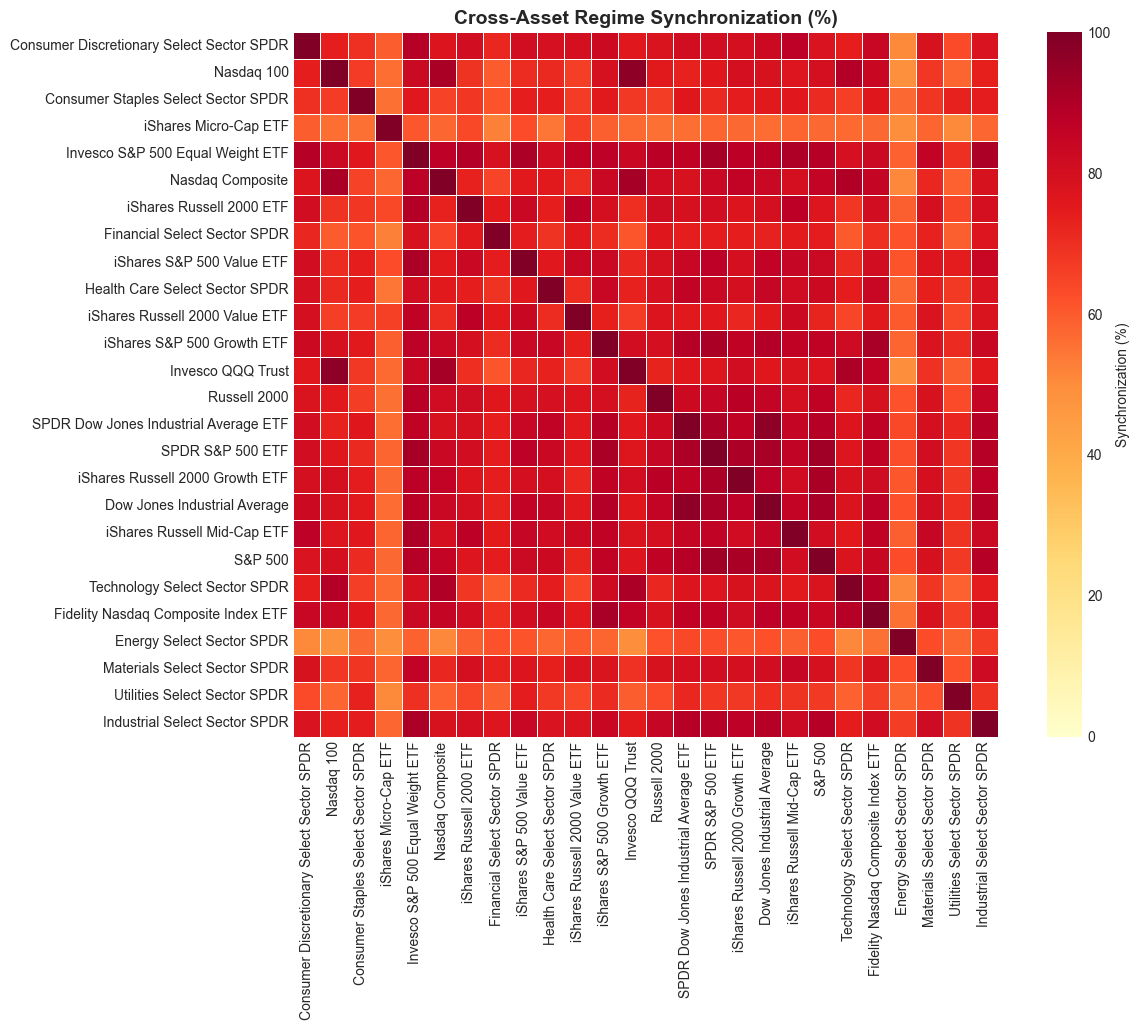


Asset Pairs with Highest Regime Synchronization:


,Asset 1,Asset 2,Sync %
35,Nasdaq 100,Invesco QQQ Trust,96.5366
261,SPDR Dow Jones Industrial Average ETF,Dow Jones Industrial Average,96.4845
273,SPDR S&P 500 ETF,S&P 500,93.2306
121,Nasdaq Composite,Invesco QQQ Trust,91.8664
104,Invesco S&P 500 Equal Weight ETF,SPDR S&P 500 ETF,91.8585
271,SPDR S&P 500 ETF,Dow Jones Industrial Average,91.7859
290,Dow Jones Industrial Average,S&P 500,91.6024
229,iShares S&P 500 Growth ETF,Fidelity Nasdaq Composite Index ETF,91.5882
223,iShares S&P 500 Growth ETF,SPDR S&P 500 ETF,91.3421
28,Nasdaq 100,Nasdaq Composite,91.2892


In [ ]:
# Calculate regime synchronization percentage
def calculate_regime_sync(regime_matrix: pd.DataFrame) -> pd.DataFrame:
    """Calculate percentage of time assets are in the same regime."""
    assets = regime_matrix.columns
    n_assets = len(assets)
    
    sync_matrix = pd.DataFrame(index=assets, columns=assets, dtype=float)
    
    for i, asset1 in enumerate(assets):
        for j, asset2 in enumerate(assets):
            if i == j:
                sync_matrix.loc[asset1, asset2] = 100.0
            else:
                # Find common dates
                common_dates = regime_matrix[[asset1, asset2]].dropna().index
                if len(common_dates) > 0:
                    same_regime = (regime_matrix.loc[common_dates, asset1] == 
                                  regime_matrix.loc[common_dates, asset2])
                    sync_matrix.loc[asset1, asset2] = same_regime.sum() / len(common_dates) * 100
    
    return sync_matrix.astype(float)

sync_matrix = calculate_regime_sync(regime_matrix)

plt.figure(figsize=(max(10, len(models)*0.5), max(8, len(models)*0.4)))
sns.heatmap(sync_matrix, annot=False, fmt='.1f', cmap='YlOrRd', 
            vmin=0, vmax=100, square=True, linewidths=0.5,
            cbar_kws={'label': 'Synchronization (%)'})
plt.title('Cross-Asset Regime Synchronization (%)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nAsset Pairs with Highest Regime Synchronization:")
print("="*80)

# Convert to long format
sync_data = []
for i, asset1 in enumerate(sync_matrix.index):
    for j, asset2 in enumerate(sync_matrix.columns):
        if i < j:  # Upper triangle only
            sync_data.append({
                'Asset 1': asset1,
                'Asset 2': asset2,
                'Sync %': sync_matrix.loc[asset1, asset2]
            })

sync_df = pd.DataFrame(sync_data).sort_values('Sync %', ascending=False)
display(sync_df.head(10))

## 14. Identify Outliers and Anomalies

In [ ]:
def identify_outliers_zscore(df: pd.DataFrame, columns: list, threshold: float = 3.0) -> pd.DataFrame:
    """
    Identify outliers using z-score method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Data to analyze
    columns : list
        Columns to check for outliers
    threshold : float
        Z-score threshold (default: 3.0)
    
    Returns:
    --------
    pd.DataFrame : Rows with outlier values
    """
    outliers = pd.DataFrame()
    
    for col in columns:
        if col in df.columns:
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            col_outliers = df[z_scores > threshold]
            
            if len(col_outliers) > 0:
                col_outliers['Outlier_Column'] = col
                col_outliers['Z_Score'] = z_scores[z_scores > threshold]
                outliers = pd.concat([outliers, col_outliers])
    
    return outliers

# Define columns to check
outlier_check_columns = [
    'KAMA_n', 'KAMA_n_fast', 'KAMA_n_slow', 'Filter_gamma',
    'Avg_Regime_Duration', 'Pct_Single_Period',
    'BIC', 'Changes_Per_100_Periods',
    'Regime_Diversity_Score'
]

# Filter available columns
available_outlier_cols = [col for col in outlier_check_columns if col in comprehensive_df.columns]

outliers = identify_outliers_zscore(comprehensive_df, available_outlier_cols, threshold=2.5)

print("Outlier Analysis (Z-score > 2.5):")
print("="*80)

if len(outliers) > 0:
    outlier_summary = outliers.groupby('Asset')['Outlier_Column'].apply(list).reset_index()
    outlier_summary.columns = ['Asset', 'Outlier Parameters']
    display(outlier_summary)
    
    print("\nDetailed Outlier Information:")
    display(outliers[['Asset', 'Outlier_Column', 'Z_Score']].sort_values('Z_Score', ascending=False))
else:
    print("✓ No significant outliers found")

Outlier Analysis (Z-score > 2.5):


,Asset,Outlier Parameters
0,Health Care Select Sector SPDR,[Pct_Single_Period]
1,iShares Micro-Cap ETF,"[KAMA_n_fast, Avg_Regime_Duration, Changes_Per..."



Detailed Outlier Information:


,Asset,Outlier_Column,Z_Score
3,iShares Micro-Cap ETF,Changes_Per_100_Periods,4.4494
3,iShares Micro-Cap ETF,KAMA_n_fast,4.3898
3,iShares Micro-Cap ETF,Avg_Regime_Duration,2.7537
9,Health Care Select Sector SPDR,Pct_Single_Period,2.6477


In [ ]:
# IQR-based outlier detection
def identify_outliers_iqr(df: pd.DataFrame, columns: list, multiplier: float = 1.5) -> pd.DataFrame:
    """
    Identify outliers using IQR method.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Data to analyze
    columns : list
        Columns to check for outliers
    multiplier : float
        IQR multiplier (default: 1.5)
    
    Returns:
    --------
    pd.DataFrame : Rows with outlier values
    """
    outliers = pd.DataFrame()
    
    for col in columns:
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - multiplier * IQR
            upper_bound = Q3 + multiplier * IQR
            
            col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].copy()
            
            if len(col_outliers) > 0:
                col_outliers['Outlier_Column'] = col
                col_outliers['Outlier_Value'] = col_outliers[col]
                col_outliers['Lower_Bound'] = lower_bound
                col_outliers['Upper_Bound'] = upper_bound
                outliers = pd.concat([outliers, col_outliers])
    
    return outliers

iqr_outliers = identify_outliers_iqr(comprehensive_df, available_outlier_cols, multiplier=1.5)

print("\nOutlier Analysis (IQR method):")
print("="*80)

if len(iqr_outliers) > 0:
    iqr_summary = iqr_outliers.groupby('Asset')['Outlier_Column'].apply(list).reset_index()
    iqr_summary.columns = ['Asset', 'Outlier Parameters']
    display(iqr_summary)
else:
    print("✓ No significant outliers found")


Outlier Analysis (IQR method):


,Asset,Outlier Parameters
0,Dow Jones Industrial Average,[BIC]
1,Fidelity Nasdaq Composite Index ETF,[KAMA_n_slow]
2,S&P 500,[BIC]
3,SPDR S&P 500 ETF,[KAMA_n_fast]
4,Utilities Select Sector SPDR,[KAMA_n_fast]
5,iShares Micro-Cap ETF,"[KAMA_n_fast, Avg_Regime_Duration, Changes_Per..."
6,iShares Russell 2000 ETF,[KAMA_n_slow]
7,iShares Russell 2000 Value ETF,[Changes_Per_100_Periods]
8,iShares Russell Mid-Cap ETF,[KAMA_n_slow]
9,iShares S&P 500 Growth ETF,[KAMA_n_fast]


In [ ]:
# Identify problematic models based on multiple criteria
def flag_problematic_models(df: pd.DataFrame) -> pd.DataFrame:
    """
    Flag models with multiple potential issues.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Comprehensive model data
    
    Returns:
    --------
    pd.DataFrame : Models with flags and issue counts
    """
    issues = df[['Asset']].copy()
    
    # Flag various issues
    issues['High_Instability'] = df['Pct_Single_Period'] > 20
    issues['Low_Differentiation'] = df['Regime_Diversity_Score'] > 0.6 if 'Regime_Diversity_Score' in df.columns else False
    issues['Short_Duration'] = df['Avg_Regime_Duration'] < 5
    issues['High_Switching'] = df['Changes_Per_100_Periods'] > 15
    issues['Poor_BIC'] = df['BIC'] > df['BIC'].quantile(0.75) if 'BIC' in df.columns else False
    
    # Count issues
    issue_cols = [col for col in issues.columns if col != 'Asset']
    issues['Total_Issues'] = issues[issue_cols].sum(axis=1)
    
    return issues.sort_values('Total_Issues', ascending=False)

problem_flags = flag_problematic_models(comprehensive_df)

print("Models Flagged for Potential Issues:")
print("="*80)

problem_models = problem_flags[problem_flags['Total_Issues'] > 0]
display(problem_models)

print(f"\n{len(problem_models)} out of {len(comprehensive_df)} models flagged with issues")

Models Flagged for Potential Issues:


,Asset,High_Instability,Low_Differentiation,Short_Duration,High_Switching,Poor_BIC,Total_Issues
3,iShares Micro-Cap ETF,False,False,False,False,True,1
4,Invesco S&P 500 Equal Weight ETF,False,False,False,False,True,1
6,iShares Russell 2000 ETF,False,False,False,False,True,1
22,Energy Select Sector SPDR,False,False,False,False,True,1
21,Fidelity Nasdaq Composite Index ETF,False,False,False,False,True,1
12,Invesco QQQ Trust,False,False,False,False,True,1
16,iShares Russell 2000 Growth ETF,False,False,False,False,True,1



7 out of 26 models flagged with issues


## 15. Generate Improvement Recommendations

In [ ]:
def generate_improvement_recommendations(
    metadata_df: pd.DataFrame,
    duration_df: pd.DataFrame,
    performance_df: pd.DataFrame,
    stability_df: pd.DataFrame,
    problem_flags: pd.DataFrame,
    regime_returns_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Generate comprehensive improvement recommendations based on all analyses.
    
    Parameters:
    -----------
    metadata_df, duration_df, performance_df, stability_df, problem_flags, regime_returns_df
        Analysis dataframes
    
    Returns:
    --------
    pd.DataFrame : Recommendations for each asset with priority scores
    """
    recommendations = []
    
    for asset in metadata_df['Asset'].unique():
        asset_recs = {'Asset': asset, 'Recommendations': [], 'Priority': 0}
        
        # Check problem flags
        asset_flags = problem_flags[problem_flags['Asset'] == asset]
        if len(asset_flags) > 0:
            flags = asset_flags.iloc[0]
            
            if flags.get('High_Instability', False):
                asset_recs['Recommendations'].append("⚠️  HIGH INSTABILITY: Increase filter gamma or KAMA n to reduce single-period regimes")
                asset_recs['Priority'] += 3
            
            if flags.get('Low_Differentiation', False):
                asset_recs['Recommendations'].append("⚠️  LOW REGIME DIFFERENTIATION: Consider increasing MSR regimes or revising KAMA parameters")
                asset_recs['Priority'] += 2
            
            if flags.get('Short_Duration', False):
                asset_recs['Recommendations'].append("⚠️  SHORT REGIME DURATION: Increase minimum regime duration filter")
                asset_recs['Priority'] += 2
            
            if flags.get('High_Switching', False):
                asset_recs['Recommendations'].append("⚠️  HIGH SWITCHING FREQUENCY: Adjust KAMA sensitivity (increase n or n_slow)")
                asset_recs['Priority'] += 2
            
            if flags.get('Poor_BIC', False):
                asset_recs['Recommendations'].append("⚠️  POOR MODEL FIT: Review parameter choices or consider alternative regime count")
                asset_recs['Priority'] += 1
        
        # Check regime returns
        asset_regime_returns = regime_returns_df[regime_returns_df['Asset'] == asset]
        if len(asset_regime_returns) >= 2:
            mean_diff = abs(asset_regime_returns['Mean'].max() - asset_regime_returns['Mean'].min())
            if mean_diff < 0.01:  # Very small annualized return difference
                asset_recs['Recommendations'].append("💡 WEAK REGIME SEPARATION: Regimes show similar returns; verify KAMA trend detection")
                asset_recs['Priority'] += 2
        
        # KAMA parameter checks
        asset_meta = metadata_df[metadata_df['Asset'] == asset].iloc[0]
        if asset_meta['KAMA_n'] < 10:
            asset_recs['Recommendations'].append("💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too sensitive to noise")
            asset_recs['Priority'] += 1
        
        if asset_meta['KAMA_n_slow'] > 100:
            asset_recs['Recommendations'].append("💡 KAMA SLOW PERIOD VERY HIGH: May miss important regime shifts")
            asset_recs['Priority'] += 1
        
        # Duration variability
        asset_dur = duration_df[duration_df['Asset'] == asset].iloc[0]
        if asset_dur['Std_Duration'] > asset_dur['Mean_Duration']:
            asset_recs['Recommendations'].append("💡 HIGH DURATION VARIABILITY: Consider tightening minimum duration constraints")
            asset_recs['Priority'] += 1
        
        # Add positive notes
        if asset_recs['Priority'] == 0:
            asset_recs['Recommendations'].append("✅ Model appears well-calibrated with no major issues detected")
        
        recommendations.append(asset_recs)
    
    recs_df = pd.DataFrame(recommendations)
    recs_df['N_Issues'] = recs_df['Recommendations'].apply(lambda x: len([r for r in x if '⚠️' in r or '💡' in r]))
    
    return recs_df.sort_values('Priority', ascending=False)

# Generate recommendations
if len(performance_df) > 0 and len(problem_flags) > 0:
    recommendations_df = generate_improvement_recommendations(
        metadata_df, duration_df, performance_df, stability_df, problem_flags, regime_returns_df
    )

    print("="*80)
    print("MODEL IMPROVEMENT RECOMMENDATIONS")
    print("="*80)
    print("\nPriority levels: Higher = More urgent\n")

    for _, row in recommendations_df.iterrows():
        print(f"\n{'='*80}")
        print(f"ASSET: {row['Asset']}")
        print(f"Priority Score: {row['Priority']} | Issues Found: {row['N_Issues']}")
        print(f"{'-'*80}")
        for rec in row['Recommendations']:
            print(f"  {rec}")
    
    print(f"\n{'='*80}")
    print(f"SUMMARY: {len(recommendations_df[recommendations_df['Priority'] > 0])} assets need attention")
    print(f"{'='*80}\n")
    
    # Export recommendations
    recommendations_export = recommendations_df.copy()
    recommendations_export['Recommendations'] = recommendations_export['Recommendations'].apply(lambda x: ' | '.join(x))
    
    print("\nRecommendations Summary Table:")
    display(recommendations_export[['Asset', 'Priority', 'N_Issues', 'Recommendations']])
else:
    print("❌ Cannot generate recommendations - missing required data")


MODEL IMPROVEMENT RECOMMENDATIONS

Priority levels: Higher = More urgent


ASSET: iShares S&P 500 Value ETF
Priority Score: 2 | Issues Found: 2
--------------------------------------------------------------------------------
  💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too sensitive to noise
  💡 HIGH DURATION VARIABILITY: Consider tightening minimum duration constraints

ASSET: iShares Russell 2000 ETF
Priority Score: 2 | Issues Found: 2
--------------------------------------------------------------------------------
  ⚠️  POOR MODEL FIT: Review parameter choices or consider alternative regime count
  💡 HIGH DURATION VARIABILITY: Consider tightening minimum duration constraints

ASSET: Invesco QQQ Trust
Priority Score: 2 | Issues Found: 2
--------------------------------------------------------------------------------
  ⚠️  POOR MODEL FIT: Review parameter choices or consider alternative regime count
  💡 HIGH DURATION VARIABILITY: Consider tightening minimum duration constraints

ASSET

,Asset,Priority,N_Issues,Recommendations
8,iShares S&P 500 Value ETF,2,2,💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too...
6,iShares Russell 2000 ETF,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
12,Invesco QQQ Trust,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
21,Fidelity Nasdaq Composite Index ETF,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
10,iShares Russell 2000 Value ETF,2,2,💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too...
22,Energy Select Sector SPDR,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
16,iShares Russell 2000 Growth ETF,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
4,Invesco S&P 500 Equal Weight ETF,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
3,iShares Micro-Cap ETF,2,2,⚠️ POOR MODEL FIT: Review parameter choices o...
2,Consumer Staples Select Sector SPDR,2,2,💡 KAMA EFFICIENCY PERIOD TOO SHORT: May be too...
